In [470]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
import sys
import copy

In [2]:
def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    return 1 - np.square(tanh(x))

def sigmoid(y):
    y[y < -700] = -700
    return 1.0/(1.0+np.exp(-y))

def d_sigmoid(x):
    z = sigmoid(x)*(1-sigmoid(x))
    return z


def softmax(x):
    m = nn.Softmax(dim=0)
    return m(torch.tensor(x)).numpy()

def d_softmax(z):
    '''
    return the jacobian of the softmax
    '''
    z = softmax(z)
    return np.diag(z) - np.outer(z,z)

def MSE(a,b):
    return np.sum(np.square(a-b), axis = 1) 

def d_MSE(output_activations, y):
    return (output_activations - y) 

In [594]:
class RNN:

    def __init__(self,input_dim,hidden_dim,output_dim,lr):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim 
        self.output_dim = output_dim
        self.w_in = np.random.uniform(-1,1, (hidden_dim, input_dim)) 
        self.w_hidden = np.random.uniform(-1,1, (hidden_dim, hidden_dim)) 
        self.b_hidden = np.random.uniform(-1,1, (hidden_dim, 1))
        self.w_out = np.random.uniform(-1,1, (output_dim, hidden_dim)) 
        self.b_out = np.random.uniform(-1,1, (output_dim, 1))
        self.loss = []
        self.lr = lr
        self.epsilon = 0.000001

    def forward(self, x):
        hidden_state = np.zeros((self.hidden_dim,1))
        T = x.shape[-1]
        prediction = np.zeros((T,1))

        for i in range(T):
            x_in = self.w_in @ x[:,i].reshape(self.input_dim,1)
            x_hid = self.w_hidden @ hidden_state + self.b_hidden
            hid_out = sigmoid(x_in + x_hid)
            hidden_state = hid_out
            x_out = self.w_out @ hid_out + self.b_out
            prediction[i] = x_out
        return prediction
    
    def update(self, x, y):
        
        dldb_hidden,dldb_out,dldw_in,dldw_hidden,dldw_out,loss = self.backprop(x, y)
        self.w_in -=  self.lr * dldw_in
        self.w_hidden -=  self.lr * dldw_hidden
        self.b_hidden -=  self.lr * dldb_hidden
        self.w_out -=  self.lr * dldw_out
        self.b_out -=  self.lr * dldb_out
        self.loss.append(loss) 
        
    def gradient_approximation(self, x, y):
        nable_w_in = np.zeros(self.w_in.shape)
        nable_w_hidden = np.zeros(self.w_hidden.shape)
        nable_w_out = np.zeros(self.w_out.shape)
        nable_b_hidden = np.zeros(self.b_hidden.shape)
        nable_b_out = np.zeros(self.b_out.shape)
        
        aprox1_w_in = np.zeros(self.w_in.shape)
        aprox2_w_in = np.zeros(self.w_in.shape)
        aprox1_w_hidden = np.zeros(self.w_hidden.shape)
        aprox2_w_hidden = np.zeros(self.w_hidden.shape)
        aprox1_w_out = np.zeros(self.w_out.shape)
        aprox2_w_out = np.zeros(self.w_out.shape)
        aprox1_b_hidden = np.zeros(self.b_hidden.shape)
        aprox2_b_hidden = np.zeros(self.b_hidden.shape)
        aprox1_b_out = np.zeros(self.b_out.shape) 
        aprox2_b_out = np.zeros(self.b_out.shape) 

        for k in range(len(self.b_hidden)):
            aprox1_b_hidden = copy.deepcopy(self.b_hidden)
            aprox2_b_hidden = copy.deepcopy(self.b_hidden)
            aprox1_b_hidden[k] += self.epsilon
            aprox2_b_hidden[k] -= self.epsilon
            
            hidden_state_1 = np.zeros((batch_size,self.hidden_dim,1))
            loss1 = np.zeros((batch_size,1))
            T = x.shape[-1]
            for i in range(T):
                x_in = self.w_in @ np.expand_dims(x[:,:,i],axis = 2)
                x_hid = self.w_hidden @ hidden_state_1 + aprox1_b_hidden
                hid_out = sigmoid(x_in + x_hid)
                hidden_state_1 = hid_out
                x_out = self.w_out @ hid_out + self.b_out
                loss1 += MSE(x_out,np.expand_dims(y[:,:,i],axis = 2))

            hidden_state_2 = np.zeros((batch_size,self.hidden_dim,1))
            loss2 = np.zeros((batch_size,1))
            T = x.shape[-1]
            
            for i in range(T):
                x_in = self.w_in @ np.expand_dims(x[:,:,i],axis = 2)
                x_hid = self.w_hidden @ hidden_state_2 + aprox2_b_hidden
                hid_out = sigmoid(x_in + x_hid)
                hidden_state_2 = hid_out
                x_out = self.w_out @ hid_out + self.b_out
                loss2 += MSE(x_out,np.expand_dims(y[:,:,i],axis = 2))

            nable_b_hidden[k] = (np.sum((loss1 - loss2) / (2*self.epsilon))) / batch_size
            
            
        for k in range(len(self.w_in)):
            for j in range(len(self.w_in[k])):
                aprox1_w_in = copy.deepcopy(self.w_in)
                aprox2_w_in = copy.deepcopy(self.w_in)
                aprox1_w_in[k][j] += self.epsilon
                aprox2_w_in[k][j] -= self.epsilon

                hidden_state_1 = np.zeros((batch_size,self.hidden_dim,1))
                loss1 = np.zeros((batch_size,1))
                T = x.shape[-1]
                for i in range(T):
                    x_in = aprox1_w_in @ np.expand_dims(x[:,:,i],axis = 2)
                    x_hid = self.w_hidden @ hidden_state_1 + self.b_hidden
                    hid_out = sigmoid(x_in + x_hid)
                    hidden_state_1 = hid_out
                    x_out = self.w_out @ hid_out + self.b_out
                    loss1 += MSE(x_out,np.expand_dims(y[:,:,i],axis = 2))

                hidden_state_2 = np.zeros((batch_size,self.hidden_dim,1))
                loss2 = np.zeros((batch_size,1))
                T = x.shape[-1]

                for i in range(T):
                    x_in = aprox2_w_in @ np.expand_dims(x[:,:,i],axis = 2)
                    x_hid = self.w_hidden @ hidden_state_2 + self.b_hidden
                    hid_out = sigmoid(x_in + x_hid)
                    hidden_state_2 = hid_out
                    x_out = self.w_out @ hid_out + + self.b_out
                    loss2 += MSE(x_out,np.expand_dims(y[:,:,i],axis = 2))

                nable_w_in[k][j] = (np.sum((loss1 - loss2) / (2*self.epsilon))) / batch_size
            
        
        for k in range(len(self.w_hidden)):
            for j in range(len(self.w_hidden[k])):
                aprox1_w_hidden = copy.deepcopy(self.w_hidden)
                aprox2_w_hidden = copy.deepcopy(self.w_hidden)
                aprox1_w_hidden[k][j] += self.epsilon
                aprox2_w_hidden[k][j] -= self.epsilon

                hidden_state_1 = np.zeros((batch_size,self.hidden_dim,1))
                loss1 = np.zeros((batch_size,1))
                T = x.shape[-1]
                for i in range(T):
                    x_in = self.w_in @ np.expand_dims(x[:,:,i],axis = 2)
                    x_hid = aprox1_w_hidden @ hidden_state_1 + self.b_hidden
                    hid_out = sigmoid(x_in + x_hid)
                    hidden_state_1 = hid_out
                    x_out = self.w_out @ hid_out + self.b_out
                    loss1 += MSE(x_out,np.expand_dims(y[:,:,i],axis = 2))

                hidden_state_2 = np.zeros((batch_size,self.hidden_dim,1))
                loss2 = np.zeros((batch_size,1))
                T = x.shape[-1]

                for i in range(T):
                    x_in = self.w_in @ np.expand_dims(x[:,:,i],axis = 2)
                    x_hid = aprox2_w_hidden @ hidden_state_2 + self.b_hidden
                    hid_out = sigmoid(x_in + x_hid)
                    hidden_state_2 = hid_out
                    x_out = self.w_out @ hid_out + + self.b_out
                    loss2 += MSE(x_out,np.expand_dims(y[:,:,i],axis = 2))

                nable_w_hidden[k][j] = (np.sum((loss1 - loss2) / (2*self.epsilon))) / batch_size
                
        for k in range(len(self.w_out)):
            for j in range(len(self.w_out[k])):
                aprox1_w_out = copy.deepcopy(self.w_out)
                aprox2_w_out = copy.deepcopy(self.w_out)
                aprox1_w_out[k][j] += self.epsilon
                aprox2_w_out[k][j] -= self.epsilon

                hidden_state_1 = np.zeros((batch_size,self.hidden_dim,1))
                loss1 = np.zeros((batch_size,1))
                T = x.shape[-1]
                for i in range(T):
                    x_in = self.w_in @ np.expand_dims(x[:,:,i],axis = 2)
                    x_hid = self.w_hidden @ hidden_state_1 + self.b_hidden
                    hid_out = sigmoid(x_in + x_hid)
                    hidden_state_1 = hid_out
                    x_out = aprox1_w_out @ hid_out + self.b_out
                    loss1 += MSE(x_out,np.expand_dims(y[:,:,i],axis = 2))

                hidden_state_2 = np.zeros((batch_size,self.hidden_dim,1))
                loss2 = np.zeros((batch_size,1))
                T = x.shape[-1]

                for i in range(T):
                    x_in = self.w_in @ np.expand_dims(x[:,:,i],axis = 2)
                    x_hid = self.w_hidden @ hidden_state_2 + self.b_hidden
                    hid_out = sigmoid(x_in + x_hid)
                    hidden_state_2 = hid_out
                    x_out = aprox2_w_out @ hid_out + + self.b_out
                    loss2 += MSE(x_out,np.expand_dims(y[:,:,i],axis = 2))

                nable_w_out[k][j] = (np.sum((loss1 - loss2) / (2*self.epsilon))) / batch_size
                
        for k in range(len(self.b_out)):
            aprox1_b_out = copy.deepcopy(self.b_out)
            aprox2_b_out = copy.deepcopy(self.b_out)
            aprox1_b_out[k] += self.epsilon
            aprox2_b_out[k] -= self.epsilon
            
            hidden_state_1 = np.zeros((batch_size,self.hidden_dim,1))
            loss1 = np.zeros((batch_size,1))
            T = x.shape[-1]
            for i in range(T):
                x_in = self.w_in @ np.expand_dims(x[:,:,i],axis = 2)
                x_hid = self.w_hidden @ hidden_state_1 + self.b_hidden
                hid_out = sigmoid(x_in + x_hid)
                hidden_state_1 = hid_out
                x_out = self.w_out @ hid_out + aprox1_b_out
                loss1 += MSE(x_out,np.expand_dims(y[:,:,i],axis = 2))


            hidden_state_2 = np.zeros((batch_size,self.hidden_dim,1))
            loss2 = np.zeros((batch_size,1))
            T = x.shape[-1]
            
            for i in range(T):
                x_in = self.w_in @ np.expand_dims(x[:,:,i],axis = 2)
                x_hid = self.w_hidden @ hidden_state_2 + self.b_hidden
                hid_out = sigmoid(x_in + x_hid)
                hidden_state_2 = hid_out
                x_out = self.w_out @ hid_out + aprox2_b_out
                loss2 += MSE(x_out,np.expand_dims(y[:,:,i],axis = 2))

            nable_b_out[k] = (np.sum((loss1 - loss2) / (2*self.epsilon))) / batch_size

        return nable_b_hidden,nable_b_out,nable_w_in,nable_w_hidden,nable_w_out

    def backprop(self, x, y):
        hidden_state = np.zeros((batch_size,self.hidden_dim,1))
        hidden_out = []
        hidden_out.append(hidden_state)
        hidden_z = []
        y_out = []
        dldw_in = np.zeros((batch_size,) + self.w_in.shape)
        dldw_hidden = np.zeros((batch_size,) + self.w_hidden.shape)
        dldb_hidden = np.zeros((batch_size,) + self.b_hidden.shape)
        dldw_out = np.zeros((batch_size,) + self.w_out.shape)
        dldb_out = np.zeros((batch_size,) + self.b_out.shape)
        loss = 0
        T = x.shape[-1]

        for i in range(T):
            x_in = self.w_in @ np.expand_dims(x[:,:,i],axis = 2)
            x_hid = self.w_hidden @ hidden_state + self.b_hidden
            hidden_z.append(x_in+x_hid)
            # hid_out = tanh(x_in + x_hid)
            hid_out = sigmoid(x_in + x_hid)
            hidden_out.append(hid_out)
            hidden_state = hid_out
            x_out = self.w_out @ hid_out + self.b_out
            y_out.append(x_out)
            loss += MSE(x_out,np.expand_dims(y[:,:,i],axis = 2))
            
        '''
        dldw_out 
        '''


        for i in range(1,T+1):
            
            dldb_out += d_MSE(y_out[-i],np.expand_dims(y[:,:,-i],axis = 2))
            dldw_out += d_MSE(y_out[-i],np.expand_dims(y[:,:,-i],axis = 2)) @ np.transpose(hidden_out[-i],(0, 2, 1)) 

        '''
        dldw_hidden
        dldw_input
        '''
        
        for i in range(1,T+1):
            
            delta = d_MSE(y_out[-i],np.expand_dims(y[:,:,-i],axis = 2))
            delta = np.transpose(self.w_out) @ delta * d_sigmoid(hidden_z[-i])
            dldb_hidden += delta
            dldw_hidden += delta @ np.transpose(hidden_out[-i-1],(0, 2, 1))
            dldw_in += delta @ np.transpose(np.expand_dims(x[:,:,-i],axis = 2),(0, 2, 1))
            
            for k in range(i+1,T+1):
                delta = np.transpose(self.w_hidden) @ delta * d_sigmoid(hidden_z[-k])
                dldb_hidden += delta
                dldw_hidden += delta @ np.transpose(hidden_out[-k-1],(0, 2, 1))
                dldw_in += delta @ np.transpose(np.expand_dims(x[:,:,-k],axis = 2),(0, 2, 1))
        
        dldb_hidden = (2 * dldb_hidden.sum(axis = 0) / batch_size) / T
        dldb_out = (2 * dldb_out.sum(axis = 0) / batch_size) / T
        dldw_in = (2 * dldw_in.sum(axis = 0) / batch_size) / T
        dldw_hidden = (2 * dldw_hidden.sum(axis = 0) / batch_size) / T
        dldw_out = (2 * dldw_out.sum(axis = 0) / batch_size) / T
        loss = (loss.sum(axis = 0) / batch_size) / T

        return (dldb_hidden,dldb_out,dldw_in,dldw_hidden,dldw_out,loss)
            

In [614]:
sinrnn = RNN(3,100,1,0.001)
Loss = []

batch_size = 50

for i in range(1000):
    idx = 0
    #nable_b_hidden,nable_b_out,nable_w_in,nable_w_hidden,nable_w_out = sinrnn.gradient_approximation(input,np.expand_dims(target,axis = 1))
    #dldb_hidden,dldb_out,dldw_in,dldw_hidden,dldw_out,loss = sinrnn.backprop(input,np.expand_dims(target,axis = 1))
    #print('approximation',(nable_w_hidden / dldw_hidden).sum())
    input = []
    target = []
    T = 50
    for j in range(batch_size):
        parameters = np.random.uniform(1,5,(3,1))
        x = np.tile(parameters,(T))
        time = np.linspace(0, 5, T)
        frequency = x[0][0]
        theta = x[1][0]
        amplitude = x[2][0]
        y = amplitude * np.sin(frequency * time + theta)
        input.append(x)
        target.append(y)
    input = np.array(input)
    target = np.array(target).reshape(batch_size,T)
    
    sinrnn.update(input,np.expand_dims(target,axis = 1))
    Loss.append(np.sum(sinrnn.loss))
    print('iteration',i,': ',np.sum(sinrnn.loss))
    sinrnn.loss.clear()


iteration 0 :  10.655986067822017
iteration 1 :  9.367559554587995
iteration 2 :  7.3724853584892625
iteration 3 :  7.020297376606924
iteration 4 :  6.917269748926967
iteration 5 :  8.00481051017522
iteration 6 :  6.61084213030653
iteration 7 :  7.240286322844543
iteration 8 :  6.302489312935628
iteration 9 :  7.070184857118402
iteration 10 :  5.431543836171852
iteration 11 :  7.035379865716553
iteration 12 :  6.572553901510863
iteration 13 :  6.259675794003759
iteration 14 :  6.809983307626277
iteration 15 :  6.220394673738509
iteration 16 :  7.107822685451038
iteration 17 :  6.015842839521482
iteration 18 :  5.216215758023002
iteration 19 :  6.898628608427587
iteration 20 :  5.927841403401843
iteration 21 :  6.659419669176962
iteration 22 :  5.817273673910286
iteration 23 :  6.993645375413272
iteration 24 :  6.317259343511154
iteration 25 :  6.297833809647957
iteration 26 :  6.232529631996312
iteration 27 :  5.981435496731157
iteration 28 :  5.378997989463959
iteration 29 :  5.603392

iteration 237 :  6.341329391385735
iteration 238 :  6.508620440389211
iteration 239 :  5.352240508304217
iteration 240 :  5.250607824911182
iteration 241 :  5.784657027528759
iteration 242 :  5.036362334842535
iteration 243 :  5.6806480627020175
iteration 244 :  5.89597664387477
iteration 245 :  4.841517907047848
iteration 246 :  4.853165815139551
iteration 247 :  5.450048016134742
iteration 248 :  5.276953181954131
iteration 249 :  5.656254188821083
iteration 250 :  5.49652919246853
iteration 251 :  5.39671857467258
iteration 252 :  5.461657759505658
iteration 253 :  5.140586150752977
iteration 254 :  5.431705206665118
iteration 255 :  5.177040022537681
iteration 256 :  5.166213997085643
iteration 257 :  5.0119121300985645
iteration 258 :  5.500153988949496
iteration 259 :  5.002830920693284
iteration 260 :  5.71046171667347
iteration 261 :  6.017983848846505
iteration 262 :  6.156465700002026
iteration 263 :  5.781417586288428
iteration 264 :  5.9380652146163335
iteration 265 :  5.99

iteration 471 :  4.948760822508674
iteration 472 :  4.985493711470473
iteration 473 :  4.973033629493283
iteration 474 :  5.321775176893152
iteration 475 :  5.304156954362082
iteration 476 :  4.59991120178368
iteration 477 :  5.3474322282454025
iteration 478 :  5.369363559535383
iteration 479 :  5.157786242694026
iteration 480 :  4.890151605730639
iteration 481 :  4.91266835602654
iteration 482 :  4.808280239038309
iteration 483 :  4.8286748796118255
iteration 484 :  5.381573493056347
iteration 485 :  4.973610164590648
iteration 486 :  4.803338659521539
iteration 487 :  5.694631116437574
iteration 488 :  4.66678626988232
iteration 489 :  5.516549702000247
iteration 490 :  5.483842399611604
iteration 491 :  5.127934166405814
iteration 492 :  4.1375092551114845
iteration 493 :  5.445819269035753
iteration 494 :  5.510631962341888
iteration 495 :  5.528646915808298
iteration 496 :  5.446354153366175
iteration 497 :  5.591453085769757
iteration 498 :  4.932856275225962
iteration 499 :  4.6

iteration 705 :  5.298152165268424
iteration 706 :  4.859320132581314
iteration 707 :  5.531410813140383
iteration 708 :  5.418713425919144
iteration 709 :  4.080847398638995
iteration 710 :  5.67811168959266
iteration 711 :  5.639618131543903
iteration 712 :  5.116096411804171
iteration 713 :  4.801003533359508
iteration 714 :  5.499793997487797
iteration 715 :  4.7731591574706185
iteration 716 :  5.582305233454448
iteration 717 :  5.358574683757101
iteration 718 :  5.35023277147379
iteration 719 :  4.822135980589446
iteration 720 :  5.65367639426066
iteration 721 :  5.820326572776801
iteration 722 :  4.862548662012987
iteration 723 :  5.495333771246358
iteration 724 :  5.421638807335719
iteration 725 :  4.62045035987899
iteration 726 :  5.560957115916522
iteration 727 :  5.2564327206768064
iteration 728 :  4.977796040105589
iteration 729 :  5.9501816114393264
iteration 730 :  5.014914950842274
iteration 731 :  5.398221869310168
iteration 732 :  5.1853355420212734
iteration 733 :  5.0

iteration 940 :  5.6513808306337605
iteration 941 :  4.4334056046535775
iteration 942 :  4.674605270871052
iteration 943 :  5.969271104512547
iteration 944 :  5.061971278787299
iteration 945 :  5.47300120107053
iteration 946 :  5.057420024974033
iteration 947 :  5.478048759857902
iteration 948 :  5.423395706997192
iteration 949 :  5.98593116353832
iteration 950 :  4.674510131930443
iteration 951 :  5.2118857804440015
iteration 952 :  4.772670826063269
iteration 953 :  5.6554610667137215
iteration 954 :  4.938917325056813
iteration 955 :  4.999491215146647
iteration 956 :  5.542655180247794
iteration 957 :  5.742822506087667
iteration 958 :  4.81655666138554
iteration 959 :  4.356065821763179
iteration 960 :  5.170109054395088
iteration 961 :  4.880307723999657
iteration 962 :  5.394853135733059
iteration 963 :  5.026116598618072
iteration 964 :  4.765317614989388
iteration 965 :  5.606715121907461
iteration 966 :  5.910492265439015
iteration 967 :  4.495704989077642
iteration 968 :  5.

In [617]:
for i in range(1000,10000):
    idx = 0
    #nable_b_hidden,nable_b_out,nable_w_in,nable_w_hidden,nable_w_out = sinrnn.gradient_approximation(input,np.expand_dims(target,axis = 1))
    #dldb_hidden,dldb_out,dldw_in,dldw_hidden,dldw_out,loss = sinrnn.backprop(input,np.expand_dims(target,axis = 1))
    #print('approximation',(nable_w_hidden / dldw_hidden).sum())
    input = []
    target = []
    T = 50
    for j in range(batch_size):
        parameters = np.random.uniform(1,5,(3,1))
        x = np.tile(parameters,(T))
        time = np.linspace(0, 5, T)
        frequency = x[0][0]
        theta = x[1][0]
        amplitude = x[2][0]
        y = amplitude * np.sin(frequency * time + theta)
        input.append(x)
        target.append(y)
    input = np.array(input)
    target = np.array(target).reshape(batch_size,T)
    
    sinrnn.update(input,np.expand_dims(target,axis = 1))
    Loss.append(np.sum(sinrnn.loss))
    print('iteration',i,': ',np.sum(sinrnn.loss))
    sinrnn.loss.clear()


iteration 1000 :  5.77422544421542
iteration 1001 :  5.136328843267855
iteration 1002 :  5.308650240043528
iteration 1003 :  5.298865930530533
iteration 1004 :  5.185580937572212
iteration 1005 :  4.779821671189233
iteration 1006 :  4.689376721417748
iteration 1007 :  5.267110674238371
iteration 1008 :  3.94280649302465
iteration 1009 :  4.764755819654308
iteration 1010 :  6.330811952057696
iteration 1011 :  4.761737710878258
iteration 1012 :  4.401871338007061
iteration 1013 :  4.782862851907671
iteration 1014 :  5.4116562569269275
iteration 1015 :  5.729613993007189
iteration 1016 :  5.06832953625396
iteration 1017 :  5.079280688662478
iteration 1018 :  5.102262588442919
iteration 1019 :  4.716625779480702
iteration 1020 :  5.2646702878150045
iteration 1021 :  4.600099886387192
iteration 1022 :  4.538598476232676
iteration 1023 :  4.967368566659761
iteration 1024 :  4.373697483367513
iteration 1025 :  5.390407632891103
iteration 1026 :  4.846671406540381
iteration 1027 :  4.573373224

iteration 1228 :  5.316021604008744
iteration 1229 :  4.74317431012189
iteration 1230 :  5.269245337614686
iteration 1231 :  3.8769953296296737
iteration 1232 :  5.272261530337732
iteration 1233 :  4.414256358916378
iteration 1234 :  4.74835882186803
iteration 1235 :  4.327968325978684
iteration 1236 :  5.43112665848422
iteration 1237 :  4.079075416850669
iteration 1238 :  4.57684300779066
iteration 1239 :  5.2829088175213625
iteration 1240 :  4.914766410149742
iteration 1241 :  4.678526598130229
iteration 1242 :  5.129810491329452
iteration 1243 :  4.566560536104436
iteration 1244 :  4.341556612869632
iteration 1245 :  5.7919528247913
iteration 1246 :  4.844852619694919
iteration 1247 :  4.474567044611773
iteration 1248 :  4.787682792916121
iteration 1249 :  4.605830009854204
iteration 1250 :  4.761839644516388
iteration 1251 :  4.313075372929823
iteration 1252 :  4.181973701397432
iteration 1253 :  4.476218157159419
iteration 1254 :  5.3120727518806685
iteration 1255 :  6.12862349831

iteration 1456 :  4.614974886012756
iteration 1457 :  5.345441775461478
iteration 1458 :  4.938680516788652
iteration 1459 :  4.563180446525478
iteration 1460 :  5.027209331863474
iteration 1461 :  4.600265632555057
iteration 1462 :  4.700122367573118
iteration 1463 :  4.411481772850967
iteration 1464 :  4.867886542906771
iteration 1465 :  3.752723105775684
iteration 1466 :  4.909104470784059
iteration 1467 :  6.131508580396344
iteration 1468 :  4.880717812616615
iteration 1469 :  4.613175539959805
iteration 1470 :  5.351641976597559
iteration 1471 :  4.94211001784699
iteration 1472 :  4.791944606358529
iteration 1473 :  4.576503669861616
iteration 1474 :  4.068163348298195
iteration 1475 :  5.086006201584897
iteration 1476 :  5.694227624840511
iteration 1477 :  4.945934485875584
iteration 1478 :  5.562976011968374
iteration 1479 :  5.146969436117889
iteration 1480 :  4.763064586011527
iteration 1481 :  5.58811345922213
iteration 1482 :  4.986241513641294
iteration 1483 :  4.6860042103

iteration 1684 :  4.5439138532568375
iteration 1685 :  4.386847452966191
iteration 1686 :  4.132081526765831
iteration 1687 :  4.956764511394035
iteration 1688 :  4.834947604110795
iteration 1689 :  4.791304496129642
iteration 1690 :  4.759117074856144
iteration 1691 :  4.166698348291194
iteration 1692 :  5.111194444246055
iteration 1693 :  4.506589150268407
iteration 1694 :  5.373078310356813
iteration 1695 :  5.103441928394044
iteration 1696 :  4.478699786743408
iteration 1697 :  4.9289950926182176
iteration 1698 :  5.180068866013336
iteration 1699 :  4.212793240906482
iteration 1700 :  5.4786620916940585
iteration 1701 :  4.355102745404454
iteration 1702 :  5.095224578560539
iteration 1703 :  4.365524273331306
iteration 1704 :  4.95005724291128
iteration 1705 :  4.748479061308168
iteration 1706 :  4.585942341481634
iteration 1707 :  3.9534179814154906
iteration 1708 :  4.423075564198526
iteration 1709 :  5.168104338637696
iteration 1710 :  4.998057299516182
iteration 1711 :  4.23927

iteration 1912 :  4.667582549354567
iteration 1913 :  4.6697464691007395
iteration 1914 :  4.7130004767295
iteration 1915 :  4.867197216809811
iteration 1916 :  4.634343444142905
iteration 1917 :  4.456895571199565
iteration 1918 :  5.498930754627834
iteration 1919 :  4.703598642592509
iteration 1920 :  5.3653650309826695
iteration 1921 :  5.311002832933887
iteration 1922 :  4.030905191068484
iteration 1923 :  5.09361634438306
iteration 1924 :  4.706027488742095
iteration 1925 :  5.161626460741817
iteration 1926 :  5.190881532480249
iteration 1927 :  5.329604400147039
iteration 1928 :  4.613508878008969
iteration 1929 :  4.569414531150787
iteration 1930 :  4.426514555256221
iteration 1931 :  4.845967860727656
iteration 1932 :  4.814432356443058
iteration 1933 :  5.254534998062008
iteration 1934 :  4.356778904429404
iteration 1935 :  5.123554634779125
iteration 1936 :  5.097714397055907
iteration 1937 :  4.975316458456778
iteration 1938 :  4.260090055745349
iteration 1939 :  3.861950781

iteration 2140 :  5.186399448421387
iteration 2141 :  4.833242126265427
iteration 2142 :  4.837347571074731
iteration 2143 :  4.564819955705329
iteration 2144 :  4.758910104600534
iteration 2145 :  4.378351780831885
iteration 2146 :  3.9377904890761273
iteration 2147 :  5.169922632461862
iteration 2148 :  5.78546346166867
iteration 2149 :  4.750651415607502
iteration 2150 :  4.196877041632493
iteration 2151 :  4.913265420697993
iteration 2152 :  5.046717231108165
iteration 2153 :  4.402048923630711
iteration 2154 :  4.497714335257762
iteration 2155 :  4.648958346226376
iteration 2156 :  4.823489968800384
iteration 2157 :  4.019212515789755
iteration 2158 :  5.574997971722764
iteration 2159 :  4.470149832909922
iteration 2160 :  4.423639748597873
iteration 2161 :  4.166257814975573
iteration 2162 :  4.2290784737401035
iteration 2163 :  4.156770311054752
iteration 2164 :  4.033838414395552
iteration 2165 :  4.126405340336929
iteration 2166 :  5.479217489452692
iteration 2167 :  4.6286206

iteration 2368 :  4.781080336087622
iteration 2369 :  4.823755177386276
iteration 2370 :  4.458974673023952
iteration 2371 :  4.8170310711377144
iteration 2372 :  4.221213285469609
iteration 2373 :  4.241281506856466
iteration 2374 :  4.676183157305735
iteration 2375 :  4.320241324787818
iteration 2376 :  4.61162073906567
iteration 2377 :  4.273182521095279
iteration 2378 :  4.774944642765077
iteration 2379 :  4.7909028271991785
iteration 2380 :  4.647148015961372
iteration 2381 :  5.351833568407972
iteration 2382 :  3.7354998399669213
iteration 2383 :  4.463904395924066
iteration 2384 :  4.943712177069249
iteration 2385 :  4.826462172763438
iteration 2386 :  4.44068551656523
iteration 2387 :  4.74066974195883
iteration 2388 :  4.995385617540779
iteration 2389 :  4.9897542714633
iteration 2390 :  4.8844183463783315
iteration 2391 :  5.463680613414042
iteration 2392 :  4.107868471230632
iteration 2393 :  4.333768150286474
iteration 2394 :  5.400799764030941
iteration 2395 :  5.089691339

iteration 2596 :  4.886965481768798
iteration 2597 :  4.211423108676829
iteration 2598 :  4.700692193400237
iteration 2599 :  5.994129805740512
iteration 2600 :  6.055216453706301
iteration 2601 :  4.855506213309193
iteration 2602 :  4.1839767607324525
iteration 2603 :  4.483926845053673
iteration 2604 :  4.361383054519817
iteration 2605 :  4.701945953141411
iteration 2606 :  4.73763840226583
iteration 2607 :  4.938853684010292
iteration 2608 :  3.7126385149361454
iteration 2609 :  3.7488376372887933
iteration 2610 :  3.7231916929006617
iteration 2611 :  4.903980045966666
iteration 2612 :  4.991558608011411
iteration 2613 :  4.4956880440465605
iteration 2614 :  4.674841978176209
iteration 2615 :  5.139415728628733
iteration 2616 :  4.488334226685448
iteration 2617 :  4.479784631025556
iteration 2618 :  4.770729236544784
iteration 2619 :  4.660200423543509
iteration 2620 :  4.420419030104364
iteration 2621 :  4.793944926048348
iteration 2622 :  5.7593149015964595
iteration 2623 :  4.008

iteration 2824 :  4.302049295542504
iteration 2825 :  4.6609228009488675
iteration 2826 :  4.566705516999196
iteration 2827 :  4.221931584842471
iteration 2828 :  4.553646770156997
iteration 2829 :  4.963716352776866
iteration 2830 :  4.662391803448263
iteration 2831 :  4.73639947922428
iteration 2832 :  5.226621619926845
iteration 2833 :  4.210372770320969
iteration 2834 :  4.871778845932477
iteration 2835 :  4.153204134058392
iteration 2836 :  4.092152227931354
iteration 2837 :  3.9638747806472634
iteration 2838 :  4.795829094265119
iteration 2839 :  4.2731130699517035
iteration 2840 :  4.3477105079101355
iteration 2841 :  5.122516095536724
iteration 2842 :  4.999466537858476
iteration 2843 :  4.55935819684277
iteration 2844 :  4.197645043173772
iteration 2845 :  4.420324541168967
iteration 2846 :  4.535965157547874
iteration 2847 :  4.272297091035899
iteration 2848 :  4.17295290237293
iteration 2849 :  4.172631781344737
iteration 2850 :  4.457214333168663
iteration 2851 :  4.4490438

iteration 3051 :  4.781302124074067
iteration 3052 :  4.514819080527745
iteration 3053 :  4.810898509099302
iteration 3054 :  4.279737466126378
iteration 3055 :  3.971801306268408
iteration 3056 :  4.284063849440255
iteration 3057 :  5.343997058620598
iteration 3058 :  4.32870765292536
iteration 3059 :  4.923509083419682
iteration 3060 :  4.617878482731038
iteration 3061 :  4.345427097506711
iteration 3062 :  4.928150091461623
iteration 3063 :  4.251877459680025
iteration 3064 :  5.145681707299079
iteration 3065 :  4.972533822694819
iteration 3066 :  3.698166779925933
iteration 3067 :  4.445228149963003
iteration 3068 :  5.0916020493512955
iteration 3069 :  4.343508228636877
iteration 3070 :  4.8494248763198975
iteration 3071 :  4.898010832486508
iteration 3072 :  4.142997719679827
iteration 3073 :  4.735417745995996
iteration 3074 :  3.7513442002386364
iteration 3075 :  4.176466374154201
iteration 3076 :  4.801938724751321
iteration 3077 :  4.433808937560279
iteration 3078 :  4.655557

iteration 3279 :  4.486211451790834
iteration 3280 :  4.423346139898688
iteration 3281 :  4.8847374450566035
iteration 3282 :  4.108522572538666
iteration 3283 :  4.968583059811912
iteration 3284 :  5.156393671499252
iteration 3285 :  4.672108055393252
iteration 3286 :  4.361638474991376
iteration 3287 :  5.036688213073031
iteration 3288 :  4.413401292004751
iteration 3289 :  5.615788789279909
iteration 3290 :  4.884463406990997
iteration 3291 :  4.346327422600569
iteration 3292 :  4.727390109625043
iteration 3293 :  4.4749762967950515
iteration 3294 :  4.412846637241613
iteration 3295 :  4.152754597260841
iteration 3296 :  4.806808313669183
iteration 3297 :  4.431713698188453
iteration 3298 :  4.267662790073785
iteration 3299 :  4.556691203906806
iteration 3300 :  4.727457485682226
iteration 3301 :  4.333666088332244
iteration 3302 :  4.7417918105439165
iteration 3303 :  4.536855063517209
iteration 3304 :  4.56121911172229
iteration 3305 :  4.715320390153998
iteration 3306 :  4.645879

iteration 3507 :  4.688029848483649
iteration 3508 :  4.9893270465028525
iteration 3509 :  4.122355495807541
iteration 3510 :  5.467721444339767
iteration 3511 :  4.909699227665349
iteration 3512 :  4.723478513813131
iteration 3513 :  4.065406003664973
iteration 3514 :  4.394939304857704
iteration 3515 :  5.200892110795813
iteration 3516 :  4.561023273067251
iteration 3517 :  4.8055085787248855
iteration 3518 :  4.7244390011601025
iteration 3519 :  4.289442064776086
iteration 3520 :  4.914070023936375
iteration 3521 :  4.542449704649441
iteration 3522 :  4.492551168758608
iteration 3523 :  3.3564645307481884
iteration 3524 :  4.725690438699596
iteration 3525 :  4.829798196949586
iteration 3526 :  4.54273255414564
iteration 3527 :  4.04681817864158
iteration 3528 :  4.33099816032961
iteration 3529 :  3.5802978962516683
iteration 3530 :  4.585076333811875
iteration 3531 :  4.229127594666221
iteration 3532 :  5.286403427256599
iteration 3533 :  4.315473450365103
iteration 3534 :  4.982370

iteration 3734 :  5.187696165491042
iteration 3735 :  3.9565244678078044
iteration 3736 :  4.633191771528813
iteration 3737 :  4.866594072798211
iteration 3738 :  3.950260717137094
iteration 3739 :  4.290155002893233
iteration 3740 :  4.729078101372022
iteration 3741 :  3.5723678924926463
iteration 3742 :  4.510671517992726
iteration 3743 :  4.588361173344391
iteration 3744 :  4.578202121242927
iteration 3745 :  4.3459918509147775
iteration 3746 :  4.485924223637898
iteration 3747 :  4.603776926982796
iteration 3748 :  4.692226768607569
iteration 3749 :  4.6433057646303215
iteration 3750 :  4.401456448697042
iteration 3751 :  5.074541670391851
iteration 3752 :  3.8408597622122578
iteration 3753 :  4.557509817229853
iteration 3754 :  3.8274661187400754
iteration 3755 :  5.273621459073712
iteration 3756 :  4.961714968185495
iteration 3757 :  3.838105311344059
iteration 3758 :  4.2974496171385645
iteration 3759 :  4.586879591409171
iteration 3760 :  4.177827275824468
iteration 3761 :  4.6

iteration 3961 :  3.848574285784591
iteration 3962 :  3.7819373111581864
iteration 3963 :  3.7690328558067576
iteration 3964 :  4.52169877333041
iteration 3965 :  4.657437023889042
iteration 3966 :  4.676101672345689
iteration 3967 :  4.290954035945133
iteration 3968 :  4.290864229768828
iteration 3969 :  4.365996941368976
iteration 3970 :  4.953539150005045
iteration 3971 :  4.902692040213475
iteration 3972 :  4.386780729254254
iteration 3973 :  4.346128777564058
iteration 3974 :  4.194225663878163
iteration 3975 :  4.597398489767656
iteration 3976 :  4.819244901139685
iteration 3977 :  4.12967335601356
iteration 3978 :  4.86717399430198
iteration 3979 :  5.3880388864250985
iteration 3980 :  4.518522119791846
iteration 3981 :  4.689106438602223
iteration 3982 :  4.327411720132743
iteration 3983 :  5.112209139733679
iteration 3984 :  4.400134397327074
iteration 3985 :  3.6761822305032217
iteration 3986 :  5.252929223502101
iteration 3987 :  3.977186138495243
iteration 3988 :  4.5586590

iteration 4188 :  4.545884032727227
iteration 4189 :  4.037090913889125
iteration 4190 :  3.804592967151769
iteration 4191 :  4.690756038356256
iteration 4192 :  4.378149518158795
iteration 4193 :  4.486225444687661
iteration 4194 :  4.152440429814307
iteration 4195 :  4.13967562080217
iteration 4196 :  4.959811052114654
iteration 4197 :  4.1554817614411945
iteration 4198 :  4.149056648124687
iteration 4199 :  4.261016397871267
iteration 4200 :  4.317797214018503
iteration 4201 :  3.6694651131222624
iteration 4202 :  4.304971117794937
iteration 4203 :  4.3177840022018295
iteration 4204 :  5.013037675560527
iteration 4205 :  4.650604697402849
iteration 4206 :  4.15761133346991
iteration 4207 :  4.236727594841106
iteration 4208 :  4.494584142324584
iteration 4209 :  4.480162647803458
iteration 4210 :  4.090857812351842
iteration 4211 :  4.0032537007226665
iteration 4212 :  4.195138165181993
iteration 4213 :  3.984422283508534
iteration 4214 :  4.218616006668933
iteration 4215 :  4.461732

iteration 4416 :  4.655108241310232
iteration 4417 :  4.955488742932353
iteration 4418 :  3.669822337622125
iteration 4419 :  3.724689858385278
iteration 4420 :  4.012688869181106
iteration 4421 :  4.908357784199168
iteration 4422 :  4.604768721362834
iteration 4423 :  3.236066504252323
iteration 4424 :  4.166468779207152
iteration 4425 :  3.9840591344085623
iteration 4426 :  4.22085023852396
iteration 4427 :  3.981287715693296
iteration 4428 :  4.163770552381094
iteration 4429 :  4.713434257303634
iteration 4430 :  4.279153195799434
iteration 4431 :  4.7662049370461315
iteration 4432 :  4.163869540045739
iteration 4433 :  3.4932353762102313
iteration 4434 :  4.1129435961069545
iteration 4435 :  3.765360447960136
iteration 4436 :  4.126597306663005
iteration 4437 :  4.004211067510769
iteration 4438 :  4.217320801188016
iteration 4439 :  4.138014986076837
iteration 4440 :  4.483132553773805
iteration 4441 :  4.234331143215158
iteration 4442 :  4.06762565973212
iteration 4443 :  4.234633

iteration 4643 :  4.5930427189897935
iteration 4644 :  4.012066327334032
iteration 4645 :  4.72036103437921
iteration 4646 :  4.6755678422303255
iteration 4647 :  4.750184926207596
iteration 4648 :  4.299897365944583
iteration 4649 :  3.8555336066952157
iteration 4650 :  3.970052374596122
iteration 4651 :  4.844459856480156
iteration 4652 :  4.897181191047975
iteration 4653 :  3.944828904330891
iteration 4654 :  3.40128017146838
iteration 4655 :  3.7906859998643654
iteration 4656 :  3.753321508784452
iteration 4657 :  4.190903930597211
iteration 4658 :  3.6475403558983017
iteration 4659 :  4.6716309478605815
iteration 4660 :  4.30727604922852
iteration 4661 :  4.575101293756822
iteration 4662 :  3.6820952822516286
iteration 4663 :  4.491013507554246
iteration 4664 :  3.656592377456547
iteration 4665 :  4.318999815319359
iteration 4666 :  3.7764634394998255
iteration 4667 :  3.793440145789155
iteration 4668 :  4.654850746564124
iteration 4669 :  4.241270518146567
iteration 4670 :  4.192

iteration 4870 :  3.9695834607656924
iteration 4871 :  4.110141464490407
iteration 4872 :  4.13176875222677
iteration 4873 :  4.179873986716658
iteration 4874 :  4.387019450737301
iteration 4875 :  4.053418819329565
iteration 4876 :  4.035574761228287
iteration 4877 :  4.169790640991123
iteration 4878 :  3.8360895018810366
iteration 4879 :  4.041448049325621
iteration 4880 :  4.296464626355768
iteration 4881 :  4.324784370237339
iteration 4882 :  4.086287986512309
iteration 4883 :  4.009466457420405
iteration 4884 :  4.291596236393532
iteration 4885 :  4.367865943760524
iteration 4886 :  3.7505916160842157
iteration 4887 :  4.558759323109243
iteration 4888 :  4.328028928051323
iteration 4889 :  3.869738138746582
iteration 4890 :  3.8860053168832813
iteration 4891 :  4.805997198927746
iteration 4892 :  4.834596197021925
iteration 4893 :  3.205106434556497
iteration 4894 :  4.039268388527735
iteration 4895 :  4.150233348542304
iteration 4896 :  4.504520057651316
iteration 4897 :  3.54324

iteration 5097 :  4.036073545037635
iteration 5098 :  4.108503067361092
iteration 5099 :  4.360014636829254
iteration 5100 :  4.039227865420052
iteration 5101 :  4.867582713023526
iteration 5102 :  4.549720245416902
iteration 5103 :  4.38739280856651
iteration 5104 :  3.5936604723091268
iteration 5105 :  4.54910582712963
iteration 5106 :  4.9964075602478735
iteration 5107 :  4.247595824856487
iteration 5108 :  4.616754178503018
iteration 5109 :  4.228081233870146
iteration 5110 :  4.272184207710333
iteration 5111 :  4.347002722778629
iteration 5112 :  4.470677688567184
iteration 5113 :  3.8231061188742497
iteration 5114 :  4.151777997742295
iteration 5115 :  3.7485016056144773
iteration 5116 :  3.278953735574463
iteration 5117 :  3.551436538109002
iteration 5118 :  4.428195465717468
iteration 5119 :  5.148396483816664
iteration 5120 :  4.043236131261289
iteration 5121 :  4.047583650939557
iteration 5122 :  4.2265568914722556
iteration 5123 :  4.407761582284013
iteration 5124 :  4.51318

iteration 5324 :  3.8201560886673387
iteration 5325 :  4.352701384483876
iteration 5326 :  3.502333603413793
iteration 5327 :  5.154263798746156
iteration 5328 :  3.7845887706539316
iteration 5329 :  4.578035491270742
iteration 5330 :  3.999202462520649
iteration 5331 :  4.1864540774181656
iteration 5332 :  3.876035951389484
iteration 5333 :  4.389626526332382
iteration 5334 :  4.774637519586764
iteration 5335 :  4.720020365932233
iteration 5336 :  4.386378288437198
iteration 5337 :  4.145505684898681
iteration 5338 :  4.330221989917144
iteration 5339 :  4.19841856464902
iteration 5340 :  4.655466607808794
iteration 5341 :  3.9992073242829957
iteration 5342 :  5.58217034687013
iteration 5343 :  3.6055033698098042
iteration 5344 :  4.667305242620322
iteration 5345 :  4.073826098229909
iteration 5346 :  3.8901229936577972
iteration 5347 :  3.791655588417689
iteration 5348 :  3.836669314233235
iteration 5349 :  4.057628606693979
iteration 5350 :  3.922433029644976
iteration 5351 :  3.9569

iteration 5551 :  3.5992549813469408
iteration 5552 :  3.9021826526335754
iteration 5553 :  4.6826925724390485
iteration 5554 :  3.798760662842723
iteration 5555 :  3.9010905868624746
iteration 5556 :  3.5135795969927024
iteration 5557 :  3.4457519691957508
iteration 5558 :  5.069385276255241
iteration 5559 :  4.646074258985192
iteration 5560 :  4.184726585777286
iteration 5561 :  5.18013109617473
iteration 5562 :  4.536251947532052
iteration 5563 :  3.4660434677433187
iteration 5564 :  3.691716425508625
iteration 5565 :  3.9468030024329797
iteration 5566 :  3.9761856646746145
iteration 5567 :  4.435261518181017
iteration 5568 :  4.041566987917163
iteration 5569 :  3.7484673700090383
iteration 5570 :  3.8271504219481742
iteration 5571 :  3.6746949052754485
iteration 5572 :  4.462520527361423
iteration 5573 :  3.878785882488768
iteration 5574 :  3.4800960507416305
iteration 5575 :  5.185715556599625
iteration 5576 :  3.800333733922027
iteration 5577 :  4.390917945887854
iteration 5578 :

iteration 5777 :  3.073521014080184
iteration 5778 :  4.235072185728525
iteration 5779 :  4.269986794699772
iteration 5780 :  3.9373816571697335
iteration 5781 :  3.739221411949178
iteration 5782 :  3.4484775663104017
iteration 5783 :  3.1197531251253383
iteration 5784 :  4.077198000441166
iteration 5785 :  3.9574622305165854
iteration 5786 :  4.388703078447286
iteration 5787 :  3.4340897919235975
iteration 5788 :  3.677459690450546
iteration 5789 :  3.066008284934789
iteration 5790 :  3.416783768806227
iteration 5791 :  4.006633809533941
iteration 5792 :  4.876948187736762
iteration 5793 :  4.920500318320917
iteration 5794 :  3.45622846817082
iteration 5795 :  3.054094382940609
iteration 5796 :  3.5341806356504515
iteration 5797 :  2.7964309556442157
iteration 5798 :  3.512130317462141
iteration 5799 :  3.7516807460924038
iteration 5800 :  4.49176154520959
iteration 5801 :  3.7843970967557583
iteration 5802 :  3.7590901579659377
iteration 5803 :  3.975720107983983
iteration 5804 :  4.

iteration 6003 :  4.5714720318409885
iteration 6004 :  3.951879411612047
iteration 6005 :  4.559492925225688
iteration 6006 :  3.120761924214499
iteration 6007 :  4.0055638191308365
iteration 6008 :  3.6919597642634425
iteration 6009 :  3.557566286022084
iteration 6010 :  3.8319471861368286
iteration 6011 :  3.965049675891488
iteration 6012 :  3.645900986039521
iteration 6013 :  3.066267142246311
iteration 6014 :  3.3622363572324554
iteration 6015 :  3.3765984652576377
iteration 6016 :  4.1532391458559985
iteration 6017 :  3.750180948437534
iteration 6018 :  4.689204966664903
iteration 6019 :  3.8715859394485492
iteration 6020 :  4.231507847522629
iteration 6021 :  3.980666814389878
iteration 6022 :  4.0080796874873
iteration 6023 :  3.548432037444239
iteration 6024 :  3.0364098740178393
iteration 6025 :  3.9046197722015386
iteration 6026 :  3.1867227170916186
iteration 6027 :  3.974284533017573
iteration 6028 :  4.942661168364759
iteration 6029 :  4.3776213925833245
iteration 6030 :  

iteration 6229 :  3.960151293796839
iteration 6230 :  3.5700015184046943
iteration 6231 :  3.887284234771393
iteration 6232 :  4.421989401888106
iteration 6233 :  3.376713004809746
iteration 6234 :  4.165829611370501
iteration 6235 :  4.405409115001369
iteration 6236 :  3.1398008524025003
iteration 6237 :  4.200840912002556
iteration 6238 :  4.091348855385202
iteration 6239 :  4.227098778383439
iteration 6240 :  4.3630758120210125
iteration 6241 :  3.589734081346229
iteration 6242 :  2.762489969635617
iteration 6243 :  3.126947171720147
iteration 6244 :  3.6274185203388463
iteration 6245 :  3.740760295842841
iteration 6246 :  3.765764951930888
iteration 6247 :  3.2409938401140237
iteration 6248 :  3.1740840636072214
iteration 6249 :  2.9617387729277582
iteration 6250 :  3.468284862452851
iteration 6251 :  3.1668244754747494
iteration 6252 :  3.691216108512163
iteration 6253 :  4.215419674788735
iteration 6254 :  3.3325648321331864
iteration 6255 :  3.5544364580041274
iteration 6256 :  

iteration 6454 :  3.1382555815602005
iteration 6455 :  4.613881684696945
iteration 6456 :  2.6305894728810144
iteration 6457 :  3.393697746505052
iteration 6458 :  3.7313651001219323
iteration 6459 :  2.9766038215923616
iteration 6460 :  3.952515043630433
iteration 6461 :  3.9362997033830025
iteration 6462 :  3.9693481828502954
iteration 6463 :  3.827460993774693
iteration 6464 :  3.965175864112683
iteration 6465 :  4.158395918197942
iteration 6466 :  4.412921167360773
iteration 6467 :  3.1368411544014294
iteration 6468 :  3.88576650517455
iteration 6469 :  3.633028480148665
iteration 6470 :  3.5154782329094347
iteration 6471 :  3.1448938871133834
iteration 6472 :  3.9458933642385863
iteration 6473 :  3.9185861913595135
iteration 6474 :  2.5024219161434793
iteration 6475 :  3.0205141379564235
iteration 6476 :  2.843220970464978
iteration 6477 :  3.2235147895390694
iteration 6478 :  2.8626841526328293
iteration 6479 :  3.263984211461909
iteration 6480 :  3.7409963705525864
iteration 648

iteration 6679 :  3.164987564675593
iteration 6680 :  3.3512026946910067
iteration 6681 :  2.3905829380154033
iteration 6682 :  2.664171442485755
iteration 6683 :  4.347703184523481
iteration 6684 :  3.7397603731014657
iteration 6685 :  2.878134520265611
iteration 6686 :  3.045927274363949
iteration 6687 :  3.5646432985048904
iteration 6688 :  3.1434267127610513
iteration 6689 :  2.7250810239577667
iteration 6690 :  3.261611334082947
iteration 6691 :  3.1552298791432976
iteration 6692 :  2.3463145071773015
iteration 6693 :  2.570004018599496
iteration 6694 :  3.344795010154508
iteration 6695 :  1.974464523902368
iteration 6696 :  2.7569855473447076
iteration 6697 :  3.576710419143682
iteration 6698 :  3.2317311128499635
iteration 6699 :  4.0625171231682495
iteration 6700 :  3.49969003553362
iteration 6701 :  3.8814350470079098
iteration 6702 :  3.7233653954832096
iteration 6703 :  2.8431007593123843
iteration 6704 :  2.485677752858932
iteration 6705 :  3.295691237863401
iteration 6706 

iteration 6905 :  3.6143258185504807
iteration 6906 :  2.5833029539105428
iteration 6907 :  2.5210286420396706
iteration 6908 :  2.826220876543851
iteration 6909 :  2.0166824192349124
iteration 6910 :  2.55873848694633
iteration 6911 :  2.5599384994681
iteration 6912 :  2.682529560714288
iteration 6913 :  3.2104349012810034
iteration 6914 :  2.5443965339146564
iteration 6915 :  2.412227097174076
iteration 6916 :  2.7124710338582303
iteration 6917 :  2.6598001122700854
iteration 6918 :  2.6531397310862097
iteration 6919 :  2.5793607060159194
iteration 6920 :  3.7566348886008383
iteration 6921 :  3.3057950163725787
iteration 6922 :  2.7974054196043063
iteration 6923 :  3.1457094312717606
iteration 6924 :  2.567924638918734
iteration 6925 :  2.9372254650155014
iteration 6926 :  2.8721719710103186
iteration 6927 :  3.818974117133439
iteration 6928 :  2.469751644751672
iteration 6929 :  2.5675049048226724
iteration 6930 :  3.600484697912396
iteration 6931 :  3.5254829381853185
iteration 693

iteration 7130 :  2.7183938339294333
iteration 7131 :  4.2530385672062
iteration 7132 :  2.529321009287613
iteration 7133 :  2.4291107422466967
iteration 7134 :  2.619375383988037
iteration 7135 :  1.8404664672971587
iteration 7136 :  2.1260437774184346
iteration 7137 :  3.920156642328077
iteration 7138 :  3.9914424710857186
iteration 7139 :  3.0894412650153606
iteration 7140 :  2.3126707959143333
iteration 7141 :  2.766400480383763
iteration 7142 :  1.9257841619018978
iteration 7143 :  2.050367206311935
iteration 7144 :  2.859521572821154
iteration 7145 :  2.5676712386014553
iteration 7146 :  2.9966411486446076
iteration 7147 :  4.507021527777956
iteration 7148 :  2.7744515641042318
iteration 7149 :  3.2072563790896886
iteration 7150 :  3.452898152913522
iteration 7151 :  3.5231947831291395
iteration 7152 :  3.0707740142627706
iteration 7153 :  3.342467503914221
iteration 7154 :  1.7662734139237495
iteration 7155 :  2.7235430099861926
iteration 7156 :  2.0862064855026685
iteration 715

iteration 7355 :  2.08408911096317
iteration 7356 :  2.1418061948425766
iteration 7357 :  1.6632108148854927
iteration 7358 :  2.619395277337659
iteration 7359 :  2.806092922832558
iteration 7360 :  3.1817661537486814
iteration 7361 :  4.530823304764768
iteration 7362 :  1.9709829308179192
iteration 7363 :  2.3029575383441374
iteration 7364 :  2.298892169437073
iteration 7365 :  1.9431578008201553
iteration 7366 :  2.4065858369730764
iteration 7367 :  2.684778656273118
iteration 7368 :  3.0467079043899155
iteration 7369 :  3.980054385123147
iteration 7370 :  2.1739041543655793
iteration 7371 :  1.8800153288202943
iteration 7372 :  1.6587794125786712
iteration 7373 :  2.426614519326999
iteration 7374 :  2.070538528821495
iteration 7375 :  1.7098465964079086
iteration 7376 :  2.344315794519749
iteration 7377 :  1.7885357068032706
iteration 7378 :  2.3604778293584316
iteration 7379 :  2.1976737634350503
iteration 7380 :  2.261478909896975
iteration 7381 :  2.3126088057482934
iteration 738

iteration 7580 :  2.4881275709258053
iteration 7581 :  3.221662501867806
iteration 7582 :  3.544813254074532
iteration 7583 :  2.286046506338812
iteration 7584 :  1.5144893226284353
iteration 7585 :  2.671685183781511
iteration 7586 :  2.6719741462226185
iteration 7587 :  2.3112626327700165
iteration 7588 :  3.167522120951261
iteration 7589 :  1.7689016386258496
iteration 7590 :  1.9441706855851562
iteration 7591 :  1.7994749826947305
iteration 7592 :  1.425789817159484
iteration 7593 :  1.5586296449027373
iteration 7594 :  1.7323010695819654
iteration 7595 :  2.3954148957700365
iteration 7596 :  1.8629054268946987
iteration 7597 :  1.9646591907663875
iteration 7598 :  1.604857984969257
iteration 7599 :  1.9133517792191506
iteration 7600 :  2.2609573870332964
iteration 7601 :  1.4477903197036073
iteration 7602 :  1.7184931122694826
iteration 7603 :  1.6565230907410438
iteration 7604 :  1.8896159380853002
iteration 7605 :  1.3495413305653263
iteration 7606 :  1.3450718770361174
iteratio

iteration 7803 :  1.5032962551558773
iteration 7804 :  1.432114301517091
iteration 7805 :  1.4950651504052916
iteration 7806 :  1.7195188064801608
iteration 7807 :  1.1290016074565432
iteration 7808 :  1.7715599576403962
iteration 7809 :  1.3521186230568867
iteration 7810 :  1.8201364991822877
iteration 7811 :  1.1180703915057373
iteration 7812 :  1.6975753506504396
iteration 7813 :  1.538270942821272
iteration 7814 :  2.1099314346204228
iteration 7815 :  1.4436333798772054
iteration 7816 :  1.8312281112183155
iteration 7817 :  1.9983548066297407
iteration 7818 :  1.6143815123932856
iteration 7819 :  1.4956228857873386
iteration 7820 :  1.615087815034116
iteration 7821 :  1.7606419908320987
iteration 7822 :  1.503715131752825
iteration 7823 :  1.6285637017689134
iteration 7824 :  1.507131005941384
iteration 7825 :  1.4428123274486213
iteration 7826 :  1.6925268330576506
iteration 7827 :  1.5261793473664569
iteration 7828 :  2.3262124448119352
iteration 7829 :  1.99012429402674
iteratio

iteration 8027 :  1.2428521808733621
iteration 8028 :  1.0405879789086014
iteration 8029 :  1.1464181829673985
iteration 8030 :  1.187641983783817
iteration 8031 :  1.0327304975221034
iteration 8032 :  1.773213203124938
iteration 8033 :  1.6853897583468669
iteration 8034 :  1.4437866029434192
iteration 8035 :  1.3960141648124555
iteration 8036 :  1.4671749306888222
iteration 8037 :  1.7718775261710877
iteration 8038 :  2.1788020274204887
iteration 8039 :  1.9710567090140998
iteration 8040 :  1.9720748958506322
iteration 8041 :  1.7820558097799324
iteration 8042 :  1.723495332539508
iteration 8043 :  1.715190216391946
iteration 8044 :  2.50128814829655
iteration 8045 :  0.8531116676469669
iteration 8046 :  1.3322159214073903
iteration 8047 :  1.3873095182737984
iteration 8048 :  1.3436913069932366
iteration 8049 :  1.2966481458008505
iteration 8050 :  1.3202120958458696
iteration 8051 :  1.2537112681004066
iteration 8052 :  1.6642419254383076
iteration 8053 :  1.1915979314641234
iterati

iteration 8250 :  1.3886323188437857
iteration 8251 :  1.28641835325092
iteration 8252 :  1.2266371133923812
iteration 8253 :  1.281136533750714
iteration 8254 :  1.4544058443879435
iteration 8255 :  1.3521591666474606
iteration 8256 :  1.5563905018514128
iteration 8257 :  1.5438704207242384
iteration 8258 :  1.472918178630239
iteration 8259 :  1.4339811866351815
iteration 8260 :  1.1920682401915015
iteration 8261 :  1.2658137657060247
iteration 8262 :  1.1636142410483075
iteration 8263 :  1.2904156452616555
iteration 8264 :  1.3518265051437697
iteration 8265 :  1.3393889334284206
iteration 8266 :  0.9599085660189562
iteration 8267 :  1.2548934410293793
iteration 8268 :  1.0669581934165009
iteration 8269 :  0.9841902611605973
iteration 8270 :  1.2066383434950072
iteration 8271 :  1.4442573322574135
iteration 8272 :  1.4881759325558164
iteration 8273 :  1.4044328557424117
iteration 8274 :  1.1738906246986978
iteration 8275 :  1.4674642656484462
iteration 8276 :  1.0755783740475366
itera

iteration 8473 :  1.680306465677081
iteration 8474 :  1.1325098398668825
iteration 8475 :  1.3823634677657433
iteration 8476 :  0.8762864866296098
iteration 8477 :  0.977117210078218
iteration 8478 :  1.0149081767723283
iteration 8479 :  1.2180931092153455
iteration 8480 :  1.0999588918640335
iteration 8481 :  0.8500092006208384
iteration 8482 :  0.8487971220059773
iteration 8483 :  1.505586943459297
iteration 8484 :  0.9952260571884356
iteration 8485 :  0.7414149725786838
iteration 8486 :  0.8942961172315812
iteration 8487 :  0.8450561599286656
iteration 8488 :  0.7338411193500413
iteration 8489 :  1.152704038336575
iteration 8490 :  0.860518129224469
iteration 8491 :  0.9878900917218566
iteration 8492 :  0.9615240351640881
iteration 8493 :  1.1316287042409043
iteration 8494 :  0.746255320614655
iteration 8495 :  1.1550347307615583
iteration 8496 :  0.9950862324440304
iteration 8497 :  0.8616045074719757
iteration 8498 :  0.69181496294758
iteration 8499 :  1.0501777768515408
iteration

iteration 8696 :  1.3801196529609323
iteration 8697 :  1.1303904466439454
iteration 8698 :  1.2828498048909307
iteration 8699 :  0.7810235026048106
iteration 8700 :  0.7388417813421903
iteration 8701 :  0.7032804177466994
iteration 8702 :  0.6132507681070812
iteration 8703 :  0.8988363358409299
iteration 8704 :  1.0233813593764858
iteration 8705 :  1.148465941113371
iteration 8706 :  1.4948702103218594
iteration 8707 :  1.4733932003977461
iteration 8708 :  1.3393226924870834
iteration 8709 :  1.2845926258039801
iteration 8710 :  1.3527206347636738
iteration 8711 :  1.621052097307916
iteration 8712 :  1.6191522711615036
iteration 8713 :  1.3421553278314715
iteration 8714 :  1.5306819080135057
iteration 8715 :  1.159973362542436
iteration 8716 :  1.5163805398393564
iteration 8717 :  1.5273822415408589
iteration 8718 :  1.5178522446637825
iteration 8719 :  1.1073126901981027
iteration 8720 :  1.1169468263557152
iteration 8721 :  1.2621907137292607
iteration 8722 :  1.8940508444465027
iter

iteration 8919 :  1.2829299022871776
iteration 8920 :  0.9824239622179144
iteration 8921 :  1.0752147283532714
iteration 8922 :  1.058466676325365
iteration 8923 :  1.011010101510538
iteration 8924 :  1.4479832530658505
iteration 8925 :  1.297001346089113
iteration 8926 :  2.0369460278552562
iteration 8927 :  1.0788520159979609
iteration 8928 :  1.0207005617308889
iteration 8929 :  0.888615804637017
iteration 8930 :  1.019578666570621
iteration 8931 :  1.0276835671178295
iteration 8932 :  1.2779598368881715
iteration 8933 :  1.187348809987105
iteration 8934 :  1.520916125818968
iteration 8935 :  1.374073321426498
iteration 8936 :  1.2814833094679425
iteration 8937 :  1.2900853176310019
iteration 8938 :  1.1858354088715777
iteration 8939 :  1.1929432888390838
iteration 8940 :  0.9178967066504045
iteration 8941 :  0.9747745366997081
iteration 8942 :  1.0142511512174266
iteration 8943 :  0.8611818246031347
iteration 8944 :  0.9044422378260845
iteration 8945 :  0.7785973024605274
iteration

iteration 9142 :  0.8453780347052353
iteration 9143 :  0.8846198170939584
iteration 9144 :  0.8836220449368626
iteration 9145 :  0.7303342318106849
iteration 9146 :  0.7420142089146576
iteration 9147 :  0.6702194628261711
iteration 9148 :  0.7304109266470185
iteration 9149 :  0.7855723643733148
iteration 9150 :  1.1153258010328007
iteration 9151 :  0.5997715581221975
iteration 9152 :  0.8210430484258368
iteration 9153 :  0.6785371779724949
iteration 9154 :  0.6680170255059324
iteration 9155 :  0.6164754927156118
iteration 9156 :  0.6062687865642465
iteration 9157 :  0.8932524335773556
iteration 9158 :  0.982445430992877
iteration 9159 :  0.7920291258916505
iteration 9160 :  0.8704980770126689
iteration 9161 :  0.7733143008230304
iteration 9162 :  0.8213183483768165
iteration 9163 :  0.6536720364375327
iteration 9164 :  1.1817850926121873
iteration 9165 :  0.9581489683830161
iteration 9166 :  0.9300580059623305
iteration 9167 :  1.1380650293214318
iteration 9168 :  0.8574896443468907
it

iteration 9365 :  1.0692166813518151
iteration 9366 :  1.0157875498473112
iteration 9367 :  1.3210442024425635
iteration 9368 :  1.0007265938334156
iteration 9369 :  0.7925380515356997
iteration 9370 :  0.9233013787611857
iteration 9371 :  0.7580280203730212
iteration 9372 :  1.023663961141886
iteration 9373 :  0.9756785148414903
iteration 9374 :  0.812031803820943
iteration 9375 :  0.6151565762570044
iteration 9376 :  0.7166980534119867
iteration 9377 :  0.7037279507461446
iteration 9378 :  0.49100900368471706
iteration 9379 :  0.5797802007182936
iteration 9380 :  0.6424733792671169
iteration 9381 :  0.7997408205758815
iteration 9382 :  0.5804917949715295
iteration 9383 :  0.5392425144363616
iteration 9384 :  0.5278599238084954
iteration 9385 :  0.8198123377539369
iteration 9386 :  0.7963530495638276
iteration 9387 :  0.5788660141966648
iteration 9388 :  0.730076759997812
iteration 9389 :  0.8273750812196028
iteration 9390 :  0.7732036564880146
iteration 9391 :  0.5856614378115682
ite

iteration 9588 :  0.784702839058844
iteration 9589 :  0.7850073446171432
iteration 9590 :  0.8967601569667093
iteration 9591 :  0.6496342087580221
iteration 9592 :  1.15162070469659
iteration 9593 :  0.6790650859912472
iteration 9594 :  0.684203140883734
iteration 9595 :  0.5946048232349423
iteration 9596 :  0.6304546220262395
iteration 9597 :  0.5239251393961566
iteration 9598 :  0.5321608483961613
iteration 9599 :  0.5346333067051766
iteration 9600 :  0.5238718103894994
iteration 9601 :  0.8400747761121374
iteration 9602 :  0.5917110113606352
iteration 9603 :  0.5215012174218212
iteration 9604 :  0.6147115262363899
iteration 9605 :  0.5502396461315363
iteration 9606 :  0.5516818752058835
iteration 9607 :  0.584894566246528
iteration 9608 :  0.4767526167084579
iteration 9609 :  0.5274231300685901
iteration 9610 :  0.43332100716804683
iteration 9611 :  0.695299071787567
iteration 9612 :  0.4715616556438487
iteration 9613 :  0.5390286194057885
iteration 9614 :  0.741114589896226
iterati

iteration 9811 :  0.6911317619774532
iteration 9812 :  0.7003269161508414
iteration 9813 :  0.5375297044117275
iteration 9814 :  0.5676320309145757
iteration 9815 :  0.7114044732935224
iteration 9816 :  0.6318642517105465
iteration 9817 :  0.5489030053190362
iteration 9818 :  0.7111034246790559
iteration 9819 :  0.6331821910320329
iteration 9820 :  0.6879228817000448
iteration 9821 :  0.6041980570332969
iteration 9822 :  0.773423374132333
iteration 9823 :  0.6058563911542154
iteration 9824 :  0.5550507943793791
iteration 9825 :  0.5073122644313481
iteration 9826 :  0.5746977161228557
iteration 9827 :  0.5838446559837704
iteration 9828 :  0.5272706746024501
iteration 9829 :  0.4078777846102301
iteration 9830 :  0.45349907520523813
iteration 9831 :  0.5975081896531407
iteration 9832 :  0.6339169124673032
iteration 9833 :  0.5232394050353534
iteration 9834 :  0.42294014071070485
iteration 9835 :  0.5010180820074798
iteration 9836 :  0.7015131568206653
iteration 9837 :  0.5744553542363012


In [620]:
for i in range(10000,15000):
    idx = 0
    #nable_b_hidden,nable_b_out,nable_w_in,nable_w_hidden,nable_w_out = sinrnn.gradient_approximation(input,np.expand_dims(target,axis = 1))
    #dldb_hidden,dldb_out,dldw_in,dldw_hidden,dldw_out,loss = sinrnn.backprop(input,np.expand_dims(target,axis = 1))
    #print('approximation',(nable_w_hidden / dldw_hidden).sum())
    input = []
    target = []
    T = 50
    for j in range(batch_size):
        parameters = np.random.uniform(1,5,(3,1))
        x = np.tile(parameters,(T))
        time = np.linspace(0, 5, T)
        frequency = x[0][0]
        theta = x[1][0]
        amplitude = x[2][0]
        y = amplitude * np.sin(frequency * time + theta)
        input.append(x)
        target.append(y)
    input = np.array(input)
    target = np.array(target).reshape(batch_size,T)
    
    sinrnn.update(input,np.expand_dims(target,axis = 1))
    Loss.append(np.sum(sinrnn.loss))
    print('iteration',i,': ',np.sum(sinrnn.loss))
    sinrnn.loss.clear()


iteration 10000 :  0.7641673152347301
iteration 10001 :  0.8137938510016365
iteration 10002 :  0.807506036603173
iteration 10003 :  0.6575094395197597
iteration 10004 :  0.47516934343871225
iteration 10005 :  0.5030966939027122
iteration 10006 :  0.5833951192673723
iteration 10007 :  0.8599213448853996
iteration 10008 :  0.664996212692872
iteration 10009 :  0.5912664457755628
iteration 10010 :  0.6553099269304858
iteration 10011 :  0.5422153631496313
iteration 10012 :  0.5836189744216945
iteration 10013 :  0.4716703356606068
iteration 10014 :  0.6767191906110347
iteration 10015 :  0.35133148470929515
iteration 10016 :  0.5459036394058029
iteration 10017 :  0.47922182295294513
iteration 10018 :  0.5338584005250607
iteration 10019 :  0.44985376871576266
iteration 10020 :  0.6463849041789949
iteration 10021 :  0.6052484754693005
iteration 10022 :  0.7428653567482377
iteration 10023 :  0.7252159301178324
iteration 10024 :  0.6903973235937287
iteration 10025 :  0.746130378400906
iteration 1

iteration 10216 :  0.6037413225280612
iteration 10217 :  0.5525266737289005
iteration 10218 :  0.457128232341713
iteration 10219 :  0.45856469384926785
iteration 10220 :  0.456682261435316
iteration 10221 :  0.435581899273833
iteration 10222 :  0.4084109087228089
iteration 10223 :  0.583932533359454
iteration 10224 :  0.5027506938692434
iteration 10225 :  0.4681594571462373
iteration 10226 :  0.6541005815514376
iteration 10227 :  0.40111225962368685
iteration 10228 :  0.44488596171702194
iteration 10229 :  0.5431096737473569
iteration 10230 :  0.5439598636736709
iteration 10231 :  0.5490963723074683
iteration 10232 :  0.6192666970403305
iteration 10233 :  0.5675691517211814
iteration 10234 :  0.46612798684272094
iteration 10235 :  0.6184671735047053
iteration 10236 :  0.8311698662533548
iteration 10237 :  0.6663601003387387
iteration 10238 :  0.6277840395694119
iteration 10239 :  0.5346836948783552
iteration 10240 :  0.5388935520375537
iteration 10241 :  0.42791624000898026
iteration 1

iteration 10432 :  0.5060536439576023
iteration 10433 :  0.4374424491487828
iteration 10434 :  0.34921492237980756
iteration 10435 :  0.5571679447355511
iteration 10436 :  0.513936612386453
iteration 10437 :  0.43254661949573964
iteration 10438 :  0.4206264481589326
iteration 10439 :  0.5337486535384441
iteration 10440 :  0.5299423014346923
iteration 10441 :  0.5468367183508256
iteration 10442 :  0.5542450745266536
iteration 10443 :  0.45921515044073496
iteration 10444 :  0.643989455038182
iteration 10445 :  0.5580438180400181
iteration 10446 :  0.5600870090736033
iteration 10447 :  0.49330559135913726
iteration 10448 :  0.45538054692260166
iteration 10449 :  0.4804130336847369
iteration 10450 :  0.4930552523293137
iteration 10451 :  0.8341931948398222
iteration 10452 :  0.5744628138039917
iteration 10453 :  0.7242948773102903
iteration 10454 :  0.6288914623197801
iteration 10455 :  0.44596871675885474
iteration 10456 :  0.6958226567682817
iteration 10457 :  0.6046156039230047
iteratio

iteration 10647 :  0.6015162708689792
iteration 10648 :  0.7290618839276012
iteration 10649 :  0.4659160370909521
iteration 10650 :  0.4561480333206921
iteration 10651 :  0.4233218608787746
iteration 10652 :  0.4992320592095759
iteration 10653 :  0.40932629630160444
iteration 10654 :  0.4403486221491167
iteration 10655 :  0.4594970414302689
iteration 10656 :  0.48806686546868194
iteration 10657 :  0.544321315036552
iteration 10658 :  0.5892458724605827
iteration 10659 :  0.4084422926249374
iteration 10660 :  0.5409416755342632
iteration 10661 :  0.4775170941813785
iteration 10662 :  0.49505574833512334
iteration 10663 :  0.3929643093754269
iteration 10664 :  0.4148381433940338
iteration 10665 :  0.41561283046116715
iteration 10666 :  0.42597992044648303
iteration 10667 :  0.45201819379564506
iteration 10668 :  0.35595225990252066
iteration 10669 :  0.5568311602807048
iteration 10670 :  0.6224955669451159
iteration 10671 :  0.5637501505996863
iteration 10672 :  0.710324331173672
iterati

iteration 10862 :  0.4639069911176275
iteration 10863 :  0.49206471421459036
iteration 10864 :  0.7840208854502662
iteration 10865 :  0.6590584206583796
iteration 10866 :  0.7177575126927668
iteration 10867 :  0.5484139024524619
iteration 10868 :  0.5827607692994738
iteration 10869 :  0.6041069116989285
iteration 10870 :  0.5378531080292508
iteration 10871 :  0.46693858395684146
iteration 10872 :  0.6841317574001767
iteration 10873 :  1.0409792806770666
iteration 10874 :  0.8108768308510466
iteration 10875 :  0.6356770601146569
iteration 10876 :  0.5997182395512565
iteration 10877 :  0.35246047414585474
iteration 10878 :  0.42093734078373535
iteration 10879 :  0.4385382984256801
iteration 10880 :  0.4742017102162228
iteration 10881 :  0.43277609578646314
iteration 10882 :  0.48034649652233646
iteration 10883 :  0.40976201673172485
iteration 10884 :  0.5516780392987359
iteration 10885 :  0.447656725360865
iteration 10886 :  0.40921028720740965
iteration 10887 :  0.48166777021779106
iter

iteration 11077 :  0.5272692891636637
iteration 11078 :  0.4204455150615828
iteration 11079 :  0.671460625808406
iteration 11080 :  0.6719267800886108
iteration 11081 :  0.5393552499065434
iteration 11082 :  0.5366665570903146
iteration 11083 :  0.7714236320132873
iteration 11084 :  0.8105125576035674
iteration 11085 :  0.5895777278818017
iteration 11086 :  0.49522830796091183
iteration 11087 :  0.3638627818232921
iteration 11088 :  0.4514535475166712
iteration 11089 :  0.48691720749832806
iteration 11090 :  0.4487695347787919
iteration 11091 :  0.47524172627059214
iteration 11092 :  0.34123038097332314
iteration 11093 :  0.42799108774286615
iteration 11094 :  0.3490291663857212
iteration 11095 :  0.48014265932350464
iteration 11096 :  0.35628177126197863
iteration 11097 :  0.42484114939965556
iteration 11098 :  0.5219721829171071
iteration 11099 :  0.397714239356557
iteration 11100 :  0.3741414942884765
iteration 11101 :  0.39435669861221917
iteration 11102 :  0.45972499136031303
iter

iteration 11292 :  0.27180198921161697
iteration 11293 :  0.3979242217859111
iteration 11294 :  0.3661437616298774
iteration 11295 :  0.35796120391530356
iteration 11296 :  0.3846950604978977
iteration 11297 :  0.4701820712778769
iteration 11298 :  0.4267377362776227
iteration 11299 :  0.39157566773476915
iteration 11300 :  0.368112924428691
iteration 11301 :  0.4407658530371759
iteration 11302 :  0.6193193289315689
iteration 11303 :  0.4813654885101939
iteration 11304 :  0.4891272155101413
iteration 11305 :  0.449429381108921
iteration 11306 :  0.3634227541192926
iteration 11307 :  0.37808584743195117
iteration 11308 :  0.3111152335582998
iteration 11309 :  0.38200105686848745
iteration 11310 :  0.5045267046419408
iteration 11311 :  0.5462256366856657
iteration 11312 :  0.43416149414181127
iteration 11313 :  0.32093702762219684
iteration 11314 :  0.357529183626961
iteration 11315 :  0.32780580993435565
iteration 11316 :  0.36909769287720606
iteration 11317 :  0.4901370529385106
iterat

iteration 11507 :  0.49510182174024037
iteration 11508 :  0.45542808205375196
iteration 11509 :  0.46283559922858586
iteration 11510 :  0.46805136718092827
iteration 11511 :  0.5308530165506253
iteration 11512 :  0.49977158278859135
iteration 11513 :  0.4197007757763523
iteration 11514 :  0.39120176780641797
iteration 11515 :  0.36113892199652164
iteration 11516 :  0.38831275703494583
iteration 11517 :  0.34847354404466857
iteration 11518 :  0.4032746652842937
iteration 11519 :  0.38007252725458
iteration 11520 :  0.46299746056162966
iteration 11521 :  0.36488837972676613
iteration 11522 :  0.3780300791240001
iteration 11523 :  0.34618444079132465
iteration 11524 :  0.5112672753049017
iteration 11525 :  0.4671135058530642
iteration 11526 :  0.3336219733946709
iteration 11527 :  0.5549096663993117
iteration 11528 :  0.28594765828184354
iteration 11529 :  0.37114993888405573
iteration 11530 :  0.4104039155075149
iteration 11531 :  0.37283528091102497
iteration 11532 :  0.3074010607107483

iteration 11721 :  0.3481526089188215
iteration 11722 :  0.42386874533258934
iteration 11723 :  0.4182391259389715
iteration 11724 :  0.41284904166299924
iteration 11725 :  0.4042574937954601
iteration 11726 :  0.3409947450943169
iteration 11727 :  0.36083551557595195
iteration 11728 :  0.34917908278367127
iteration 11729 :  0.41529384302938666
iteration 11730 :  0.35400853735393534
iteration 11731 :  0.3979378184419695
iteration 11732 :  0.45627354860138575
iteration 11733 :  0.3914455422211418
iteration 11734 :  0.39373268311529896
iteration 11735 :  0.37071820546649836
iteration 11736 :  0.3017920261579627
iteration 11737 :  0.30012597928162554
iteration 11738 :  0.3243340678682042
iteration 11739 :  0.37624700122157295
iteration 11740 :  0.36632907231999695
iteration 11741 :  0.4271445699051882
iteration 11742 :  0.31510074569833674
iteration 11743 :  0.29804808199898764
iteration 11744 :  0.30461309293303135
iteration 11745 :  0.30752375328917686
iteration 11746 :  0.3639722191425

iteration 11935 :  0.33040156332557413
iteration 11936 :  0.30961200264948663
iteration 11937 :  0.3475230081607556
iteration 11938 :  0.3995287262493695
iteration 11939 :  0.33343878868536164
iteration 11940 :  0.48132420226945205
iteration 11941 :  0.5173159650891649
iteration 11942 :  0.550294727622057
iteration 11943 :  0.5046258560923518
iteration 11944 :  0.43802397986354075
iteration 11945 :  0.4772603006628392
iteration 11946 :  0.36275154666029347
iteration 11947 :  0.3174492905891318
iteration 11948 :  0.33590062302945556
iteration 11949 :  0.3590875873576923
iteration 11950 :  0.35713579058554673
iteration 11951 :  0.331580791210381
iteration 11952 :  0.3112248758282609
iteration 11953 :  0.4096461100885709
iteration 11954 :  0.2936454450875653
iteration 11955 :  0.3801953524839665
iteration 11956 :  0.31127277540935683
iteration 11957 :  0.3494914585578675
iteration 11958 :  0.2766452552758743
iteration 11959 :  0.3894116078341284
iteration 11960 :  0.2790429490563642
itera

iteration 12149 :  0.31253988267171423
iteration 12150 :  0.33918936762409335
iteration 12151 :  0.298890349499767
iteration 12152 :  0.3588160128357484
iteration 12153 :  0.2927164963718909
iteration 12154 :  0.31670037400148815
iteration 12155 :  0.306346754804521
iteration 12156 :  0.4619938366737304
iteration 12157 :  0.3185562812705894
iteration 12158 :  0.269707298211349
iteration 12159 :  0.3049300492211911
iteration 12160 :  0.2514840745154696
iteration 12161 :  0.3522745793341957
iteration 12162 :  0.38841482542191236
iteration 12163 :  0.3344173202262818
iteration 12164 :  0.4375587975155886
iteration 12165 :  0.3470516632265165
iteration 12166 :  0.3019622816510572
iteration 12167 :  0.31095603254712634
iteration 12168 :  0.3512411126692639
iteration 12169 :  0.37755222532568067
iteration 12170 :  0.2980356750157274
iteration 12171 :  0.35188050418026273
iteration 12172 :  0.2591400459877611
iteration 12173 :  0.3471685439497634
iteration 12174 :  0.3924589934468193
iteratio

iteration 12364 :  0.36583057224050164
iteration 12365 :  0.41583259701288766
iteration 12366 :  0.34717302943304185
iteration 12367 :  0.3514467756217626
iteration 12368 :  0.35348176333210146
iteration 12369 :  0.30378421715091863
iteration 12370 :  0.27419360444044466
iteration 12371 :  0.25850615416255684
iteration 12372 :  0.32318976887779854
iteration 12373 :  0.2816954435770718
iteration 12374 :  0.2953719698067521
iteration 12375 :  0.41212106197077836
iteration 12376 :  0.3126132197986708
iteration 12377 :  0.3084240202876937
iteration 12378 :  0.4023612175639042
iteration 12379 :  0.49034205117602453
iteration 12380 :  0.2773266772509304
iteration 12381 :  0.36678325217336494
iteration 12382 :  0.2735705223861747
iteration 12383 :  0.2746851725903905
iteration 12384 :  0.27632022954131585
iteration 12385 :  0.39540997290265495
iteration 12386 :  0.31627797315773465
iteration 12387 :  0.3381370320167828
iteration 12388 :  0.3291556164471926
iteration 12389 :  0.348488490940955

iteration 12578 :  0.5051249227684669
iteration 12579 :  0.5012107028582503
iteration 12580 :  0.3547922971264621
iteration 12581 :  0.30677015427139415
iteration 12582 :  0.2731329514337203
iteration 12583 :  0.3614381737831293
iteration 12584 :  0.3638993477962572
iteration 12585 :  0.29869660793618547
iteration 12586 :  0.40010413912461873
iteration 12587 :  0.3883964135701183
iteration 12588 :  0.3665375844923166
iteration 12589 :  0.37838346638220605
iteration 12590 :  0.3716809622905274
iteration 12591 :  0.42355615010952347
iteration 12592 :  0.3100422977335561
iteration 12593 :  0.37806012728997734
iteration 12594 :  0.34554270173583873
iteration 12595 :  0.3751273517816985
iteration 12596 :  0.4482493023150167
iteration 12597 :  0.37695570690171687
iteration 12598 :  0.3452208911069223
iteration 12599 :  0.2892830008633936
iteration 12600 :  0.35182119941127543
iteration 12601 :  0.3188761503672357
iteration 12602 :  0.2461331300269992
iteration 12603 :  0.3416082738125917
ite

iteration 12792 :  0.4531597148078839
iteration 12793 :  0.46993989668831504
iteration 12794 :  0.3863842493320261
iteration 12795 :  0.31007232881838687
iteration 12796 :  0.42656610322691224
iteration 12797 :  0.3588616134303606
iteration 12798 :  0.30788480139101826
iteration 12799 :  0.30346347471137847
iteration 12800 :  0.23455454088865185
iteration 12801 :  0.3841995298459198
iteration 12802 :  0.27578885840511175
iteration 12803 :  0.29613601640537146
iteration 12804 :  0.3751796779954236
iteration 12805 :  0.2995762701069014
iteration 12806 :  0.3450307795955533
iteration 12807 :  0.29277314210510996
iteration 12808 :  0.35907879917385627
iteration 12809 :  0.3178145501328281
iteration 12810 :  0.27468961858154
iteration 12811 :  0.3913518756346801
iteration 12812 :  0.31392607376774617
iteration 12813 :  0.38762235656233296
iteration 12814 :  0.34712894003558764
iteration 12815 :  0.2962574478015147
iteration 12816 :  0.4169727494329429
iteration 12817 :  0.43051867271338834


iteration 13006 :  0.3465536253249042
iteration 13007 :  0.3123342297385035
iteration 13008 :  0.23284768795849847
iteration 13009 :  0.26280519498251287
iteration 13010 :  0.3067151162757
iteration 13011 :  0.27543488961970236
iteration 13012 :  0.21187700242057594
iteration 13013 :  0.26881368440883224
iteration 13014 :  0.29908871934084014
iteration 13015 :  0.3166015606770641
iteration 13016 :  0.2796746379249864
iteration 13017 :  0.354056914650425
iteration 13018 :  0.2955147352043228
iteration 13019 :  0.27762050286452583
iteration 13020 :  0.3361038591645461
iteration 13021 :  0.35812499809968557
iteration 13022 :  0.2693133133278824
iteration 13023 :  0.3597777948697458
iteration 13024 :  0.282680792709989
iteration 13025 :  0.25162354265805736
iteration 13026 :  0.24413761611253582
iteration 13027 :  0.3052062550825038
iteration 13028 :  0.2685356145971165
iteration 13029 :  0.398277058228881
iteration 13030 :  0.3500060131568491
iteration 13031 :  0.5217111407299452
iteratio

iteration 13220 :  0.31424207750058275
iteration 13221 :  0.3680197205858861
iteration 13222 :  0.3310703042342557
iteration 13223 :  0.3839162813021562
iteration 13224 :  0.3204359021033551
iteration 13225 :  0.3179405913556147
iteration 13226 :  0.32082345384281874
iteration 13227 :  0.2919734878170475
iteration 13228 :  0.311449145971393
iteration 13229 :  0.3328831544477314
iteration 13230 :  0.2816025037593184
iteration 13231 :  0.2699560155899057
iteration 13232 :  0.3150665872090616
iteration 13233 :  0.3491521213149287
iteration 13234 :  0.37252337850315054
iteration 13235 :  0.3234548414705807
iteration 13236 :  0.28619330546150584
iteration 13237 :  0.42348892307434
iteration 13238 :  0.27329052021809713
iteration 13239 :  0.27190997446249315
iteration 13240 :  0.24022408365945477
iteration 13241 :  0.2819888181977619
iteration 13242 :  0.24601108410762457
iteration 13243 :  0.23541373048156097
iteration 13244 :  0.23479660460209953
iteration 13245 :  0.33470458313870904
iter

iteration 13434 :  0.3423085235120562
iteration 13435 :  0.23716245038959236
iteration 13436 :  0.25245302873254394
iteration 13437 :  0.2226129935027521
iteration 13438 :  0.23316355348889042
iteration 13439 :  0.2937285512083749
iteration 13440 :  0.24159297363814516
iteration 13441 :  0.3352971876781243
iteration 13442 :  0.34276463989993233
iteration 13443 :  0.3595016219434585
iteration 13444 :  0.2931751750529086
iteration 13445 :  0.3187770835087447
iteration 13446 :  0.22655872805465588
iteration 13447 :  0.27848228479496534
iteration 13448 :  0.2836726412756772
iteration 13449 :  0.30264196683347516
iteration 13450 :  0.3307943453208974
iteration 13451 :  0.30983811744034595
iteration 13452 :  0.20434073786477425
iteration 13453 :  0.3598558416557662
iteration 13454 :  0.3137444656259558
iteration 13455 :  0.34939371992260443
iteration 13456 :  0.3026688872423579
iteration 13457 :  0.2505805597832278
iteration 13458 :  0.3558667252613673
iteration 13459 :  0.32420870511554206


iteration 13648 :  0.299908534231904
iteration 13649 :  0.2766069685683456
iteration 13650 :  0.2750357296408589
iteration 13651 :  0.33223126673251424
iteration 13652 :  0.2679012843825707
iteration 13653 :  0.2288948681125403
iteration 13654 :  0.24361200927982832
iteration 13655 :  0.33805402500827036
iteration 13656 :  0.21752814824498568
iteration 13657 :  0.2185727231399081
iteration 13658 :  0.37968773388202803
iteration 13659 :  0.2846808315027855
iteration 13660 :  0.3548479695774079
iteration 13661 :  0.2840220727455709
iteration 13662 :  0.33442717266124644
iteration 13663 :  0.31040679161472257
iteration 13664 :  0.31044843326297294
iteration 13665 :  0.2510522608452583
iteration 13666 :  0.28244029760943223
iteration 13667 :  0.3953185783706226
iteration 13668 :  0.292399716300856
iteration 13669 :  0.2746489524217307
iteration 13670 :  0.3392258465571161
iteration 13671 :  0.21942609059823126
iteration 13672 :  0.29614284495797916
iteration 13673 :  0.2614632584513981
ite

iteration 13862 :  0.2467934836823154
iteration 13863 :  0.25721580540800615
iteration 13864 :  0.24979015839554472
iteration 13865 :  0.2702526256601789
iteration 13866 :  0.23749325998922174
iteration 13867 :  0.22071984953773785
iteration 13868 :  0.20873667812690383
iteration 13869 :  0.23453878537316344
iteration 13870 :  0.23392909627093808
iteration 13871 :  0.2519995527061548
iteration 13872 :  0.26955730819453755
iteration 13873 :  0.22196580789988102
iteration 13874 :  0.26443857913431
iteration 13875 :  0.22489649419516
iteration 13876 :  0.3735685017209246
iteration 13877 :  0.26385646522613243
iteration 13878 :  0.2506101963818261
iteration 13879 :  0.2957712583291557
iteration 13880 :  0.31285319208324625
iteration 13881 :  0.2604860784476404
iteration 13882 :  0.3051045897971419
iteration 13883 :  0.28016848823615714
iteration 13884 :  0.3502611666922886
iteration 13885 :  0.27790949918721664
iteration 13886 :  0.2609684464090581
iteration 13887 :  0.19798473770295133
it

iteration 14075 :  0.20206509503131367
iteration 14076 :  0.2732667773205157
iteration 14077 :  0.24025459472548558
iteration 14078 :  0.3137305263594663
iteration 14079 :  0.3605657854963535
iteration 14080 :  0.27255554322255354
iteration 14081 :  0.26538139865536164
iteration 14082 :  0.22166833672331168
iteration 14083 :  0.19969995186142409
iteration 14084 :  0.2311755159357581
iteration 14085 :  0.22884591620111114
iteration 14086 :  0.262868043813056
iteration 14087 :  0.26045559385890454
iteration 14088 :  0.26609035292947836
iteration 14089 :  0.21701342712117294
iteration 14090 :  0.34570719184916476
iteration 14091 :  0.43537256445405687
iteration 14092 :  0.3547998966504493
iteration 14093 :  0.3132337023592604
iteration 14094 :  0.2563206365898862
iteration 14095 :  0.28141852343471374
iteration 14096 :  0.20359381198681248
iteration 14097 :  0.2169773298968669
iteration 14098 :  0.18934401433491485
iteration 14099 :  0.2132356399185944
iteration 14100 :  0.238253084220868

iteration 14288 :  0.23473461997401504
iteration 14289 :  0.21872267488539435
iteration 14290 :  0.22678454484245114
iteration 14291 :  0.28086523289784543
iteration 14292 :  0.23193249376438135
iteration 14293 :  0.239299680040975
iteration 14294 :  0.3532881622258832
iteration 14295 :  0.22699681904576507
iteration 14296 :  0.18145890004021953
iteration 14297 :  0.25887042118911585
iteration 14298 :  0.25302471425587425
iteration 14299 :  0.2561859689044281
iteration 14300 :  0.26421901521423374
iteration 14301 :  0.24504384521755437
iteration 14302 :  0.2745834107787917
iteration 14303 :  0.23359787238513685
iteration 14304 :  0.2963983788978038
iteration 14305 :  0.3057980058821762
iteration 14306 :  0.2175630392005688
iteration 14307 :  0.2916544604410521
iteration 14308 :  0.2789125950274958
iteration 14309 :  0.29568254872507577
iteration 14310 :  0.2651475039550586
iteration 14311 :  0.22533802148224302
iteration 14312 :  0.2516837754943324
iteration 14313 :  0.1976761770769674

iteration 14501 :  0.30939605023352057
iteration 14502 :  0.2086232082334309
iteration 14503 :  0.2412449224947597
iteration 14504 :  0.22730064231347716
iteration 14505 :  0.2975855721759362
iteration 14506 :  0.1690812727880455
iteration 14507 :  0.28660931297533887
iteration 14508 :  0.21167311392209823
iteration 14509 :  0.22450352005194674
iteration 14510 :  0.21604210221401882
iteration 14511 :  0.30136350021237457
iteration 14512 :  0.24175440309102147
iteration 14513 :  0.20947595153748166
iteration 14514 :  0.2317706629500584
iteration 14515 :  0.2805945816345982
iteration 14516 :  0.22047783083629593
iteration 14517 :  0.3476919372498541
iteration 14518 :  0.33859214351323497
iteration 14519 :  0.34781516117916217
iteration 14520 :  0.2145336795537595
iteration 14521 :  0.1862725723064521
iteration 14522 :  0.20965783913458808
iteration 14523 :  0.17887998755253817
iteration 14524 :  0.23506696277571948
iteration 14525 :  0.21124236518038908
iteration 14526 :  0.2559510534954

iteration 14715 :  0.2532652366520083
iteration 14716 :  0.22036156701567486
iteration 14717 :  0.3075582002425902
iteration 14718 :  0.23214655053719568
iteration 14719 :  0.22475492961531948
iteration 14720 :  0.22964709347945583
iteration 14721 :  0.2022694459069925
iteration 14722 :  0.2884053902859857
iteration 14723 :  0.23520057865493335
iteration 14724 :  0.20224372710034838
iteration 14725 :  0.15743464421056555
iteration 14726 :  0.3266498931885627
iteration 14727 :  0.2695524840890039
iteration 14728 :  0.27303174653373474
iteration 14729 :  0.2223567094833413
iteration 14730 :  0.23889520270439657
iteration 14731 :  0.1739169446405352
iteration 14732 :  0.22329711155320112
iteration 14733 :  0.2164100094847588
iteration 14734 :  0.22322967371696284
iteration 14735 :  0.22583637970901463
iteration 14736 :  0.23161791759126507
iteration 14737 :  0.36257580145252233
iteration 14738 :  0.3382840698319604
iteration 14739 :  0.22628656551494405
iteration 14740 :  0.29841574010571

iteration 14928 :  0.25655622363963543
iteration 14929 :  0.35801632455984356
iteration 14930 :  0.283436137053793
iteration 14931 :  0.2592870450844742
iteration 14932 :  0.27990683417817275
iteration 14933 :  0.24666880704991495
iteration 14934 :  0.33777677328681216
iteration 14935 :  0.20894034562631414
iteration 14936 :  0.28246630966368014
iteration 14937 :  0.3171678840422984
iteration 14938 :  0.3710076104374989
iteration 14939 :  0.26424854268278536
iteration 14940 :  0.24781495259597475
iteration 14941 :  0.2658579992311967
iteration 14942 :  0.21546465976956675
iteration 14943 :  0.2428065577855633
iteration 14944 :  0.2250531525772475
iteration 14945 :  0.21295390471902256
iteration 14946 :  0.2145998439907388
iteration 14947 :  0.31783366938502194
iteration 14948 :  0.2886150997815807
iteration 14949 :  0.2919602119324093
iteration 14950 :  0.33595547344560645
iteration 14951 :  0.2944962216866854
iteration 14952 :  0.21407981044445823
iteration 14953 :  0.2240427868992521

In [637]:
for i in range(15000,20000):
    idx = 0
    #nable_b_hidden,nable_b_out,nable_w_in,nable_w_hidden,nable_w_out = sinrnn.gradient_approximation(input,np.expand_dims(target,axis = 1))
    #dldb_hidden,dldb_out,dldw_in,dldw_hidden,dldw_out,loss = sinrnn.backprop(input,np.expand_dims(target,axis = 1))
    #print('approximation',(nable_w_hidden / dldw_hidden).sum())
    input = []
    target = []
    T = 50
    for j in range(batch_size):
        parameters = np.random.uniform(1,5,(3,1))
        x = np.tile(parameters,(T))
        time = np.linspace(0, 5, T)
        frequency = x[0][0]
        theta = x[1][0]
        amplitude = x[2][0]
        y = amplitude * np.sin(frequency * time + theta)
        input.append(x)
        target.append(y)
    input = np.array(input)
    target = np.array(target).reshape(batch_size,T)
    
    sinrnn.update(input,np.expand_dims(target,axis = 1))
    Loss.append(np.sum(sinrnn.loss))
    print('iteration',i,': ',np.sum(sinrnn.loss))
    sinrnn.loss.clear()

iteration 15000 :  0.15980798302421556
iteration 15001 :  0.17648904159434595
iteration 15002 :  0.24583070169589993
iteration 15003 :  0.2188037614905012
iteration 15004 :  0.26040233783539796
iteration 15005 :  0.3452244381919561
iteration 15006 :  0.2591508634804749
iteration 15007 :  0.23478873448414014
iteration 15008 :  0.23630371491429922
iteration 15009 :  0.17132491666393235
iteration 15010 :  0.23253937293526922
iteration 15011 :  0.24588956665477227
iteration 15012 :  0.20474576541964726
iteration 15013 :  0.2529292649317037
iteration 15014 :  0.22444100615849433
iteration 15015 :  0.17336346742558922
iteration 15016 :  0.2735874670603977
iteration 15017 :  0.17459051653144972
iteration 15018 :  0.23803299369316455
iteration 15019 :  0.19774590875678424
iteration 15020 :  0.24036064060575912
iteration 15021 :  0.28632528029033893
iteration 15022 :  0.31069096925245454
iteration 15023 :  0.23076707634101218
iteration 15024 :  0.23928115108019948
iteration 15025 :  0.240173035

iteration 15213 :  0.29700744123875505
iteration 15214 :  0.34641953767325395
iteration 15215 :  0.3313746972560901
iteration 15216 :  0.3117094954427765
iteration 15217 :  0.24369975132297408
iteration 15218 :  0.19920428425469253
iteration 15219 :  0.2419470928000176
iteration 15220 :  0.19943381810386746
iteration 15221 :  0.18859490271264906
iteration 15222 :  0.20819320736527186
iteration 15223 :  0.19558806932746875
iteration 15224 :  0.19150723198681902
iteration 15225 :  0.24893165825935465
iteration 15226 :  0.19035268968895325
iteration 15227 :  0.20804768391347983
iteration 15228 :  0.2085108225803781
iteration 15229 :  0.1724337920306398
iteration 15230 :  0.25147599592499337
iteration 15231 :  0.15984890671436916
iteration 15232 :  0.1895053653431549
iteration 15233 :  0.1716199146353243
iteration 15234 :  0.23368130707534593
iteration 15235 :  0.16497982574158399
iteration 15236 :  0.15333754616047518
iteration 15237 :  0.21745631803440232
iteration 15238 :  0.20117262091

iteration 15426 :  0.2331396096501596
iteration 15427 :  0.23827808191604183
iteration 15428 :  0.17020887946659333
iteration 15429 :  0.257775257088277
iteration 15430 :  0.21918446627267632
iteration 15431 :  0.2060158415574573
iteration 15432 :  0.2057132478104273
iteration 15433 :  0.22145500934451096
iteration 15434 :  0.2049021931426762
iteration 15435 :  0.19706908901754094
iteration 15436 :  0.24655578431506434
iteration 15437 :  0.178675526916302
iteration 15438 :  0.17966019306121794
iteration 15439 :  0.2204099304296035
iteration 15440 :  0.18172757529574657
iteration 15441 :  0.20964712133737337
iteration 15442 :  0.2710765545868982
iteration 15443 :  0.1689802940761243
iteration 15444 :  0.19502866409809042
iteration 15445 :  0.24341657906857914
iteration 15446 :  0.19906672331406114
iteration 15447 :  0.21832770433975202
iteration 15448 :  0.19958788873056538
iteration 15449 :  0.22549904125678963
iteration 15450 :  0.3409628248950639
iteration 15451 :  0.2207291197327429

iteration 15639 :  0.22297888874018615
iteration 15640 :  0.25890984417530033
iteration 15641 :  0.19023658404088858
iteration 15642 :  0.2122251195876131
iteration 15643 :  0.24074991834314458
iteration 15644 :  0.16671967399705184
iteration 15645 :  0.1985212204981192
iteration 15646 :  0.2520222098725276
iteration 15647 :  0.27426285989502897
iteration 15648 :  0.2327660142195603
iteration 15649 :  0.3837561191017428
iteration 15650 :  0.3138006388766744
iteration 15651 :  0.3374733823809409
iteration 15652 :  0.2653465990103207
iteration 15653 :  0.3194646805059905
iteration 15654 :  0.3669831860455921
iteration 15655 :  0.38811133064834097
iteration 15656 :  0.4734987986228274
iteration 15657 :  0.5865858227602895
iteration 15658 :  0.5716727689192433
iteration 15659 :  0.8444122106763671
iteration 15660 :  0.9006064506719237
iteration 15661 :  1.3889236704874008
iteration 15662 :  0.34653297135262773
iteration 15663 :  0.21317124964515888
iteration 15664 :  0.17406810595817235
it

iteration 15852 :  0.24891357018235766
iteration 15853 :  0.2833746079915275
iteration 15854 :  0.24613079086963094
iteration 15855 :  0.23781249651892045
iteration 15856 :  0.22102268085991036
iteration 15857 :  0.2197189282796721
iteration 15858 :  0.2283300137709632
iteration 15859 :  0.226245515629074
iteration 15860 :  0.21113143267124676
iteration 15861 :  0.23324527388285965
iteration 15862 :  0.20408260326507777
iteration 15863 :  0.17632938671927398
iteration 15864 :  0.21535125853815093
iteration 15865 :  0.19786753471177218
iteration 15866 :  0.20741837423687162
iteration 15867 :  0.17561115823423065
iteration 15868 :  0.19635752453312666
iteration 15869 :  0.1867270887904807
iteration 15870 :  0.1869858984851701
iteration 15871 :  0.21064069115232478
iteration 15872 :  0.1526165177153703
iteration 15873 :  0.25129755516778085
iteration 15874 :  0.19820534033542336
iteration 15875 :  0.17774058063776493
iteration 15876 :  0.18713586618870534
iteration 15877 :  0.226809897110

iteration 16065 :  0.22889845352937122
iteration 16066 :  0.2635135585690833
iteration 16067 :  0.23117390372564406
iteration 16068 :  0.17326563836552297
iteration 16069 :  0.19699752947683588
iteration 16070 :  0.2115846296916047
iteration 16071 :  0.20774373323705603
iteration 16072 :  0.27294864035665806
iteration 16073 :  0.28078793036117244
iteration 16074 :  0.3224871702998678
iteration 16075 :  0.20130660813466075
iteration 16076 :  0.2553463158090645
iteration 16077 :  0.2359517280626124
iteration 16078 :  0.23573945381122305
iteration 16079 :  0.2699833984622479
iteration 16080 :  0.22633004829121436
iteration 16081 :  0.21614254631388172
iteration 16082 :  0.23020600088979112
iteration 16083 :  0.28130356002973866
iteration 16084 :  0.16296214655561872
iteration 16085 :  0.18741332178974512
iteration 16086 :  0.16519936748635075
iteration 16087 :  0.1572089441192244
iteration 16088 :  0.17976167133310703
iteration 16089 :  0.2257573783629671
iteration 16090 :  0.182322138766

iteration 16278 :  0.2505286279788943
iteration 16279 :  0.27818069257572253
iteration 16280 :  0.39209588315646715
iteration 16281 :  0.4353223537776725
iteration 16282 :  0.2256758656866377
iteration 16283 :  0.22146688091979544
iteration 16284 :  0.24708440460323455
iteration 16285 :  0.20498993988981284
iteration 16286 :  0.29954586529741467
iteration 16287 :  0.20790993953753353
iteration 16288 :  0.18212081104262004
iteration 16289 :  0.26369729565405026
iteration 16290 :  0.1795558651316402
iteration 16291 :  0.19859494182537113
iteration 16292 :  0.18389167425499264
iteration 16293 :  0.18782481495082448
iteration 16294 :  0.19198808553783206
iteration 16295 :  0.18386741949913524
iteration 16296 :  0.19985795082593336
iteration 16297 :  0.18882800873326627
iteration 16298 :  0.19972498175039138
iteration 16299 :  0.18116374938281138
iteration 16300 :  0.2384970082465604
iteration 16301 :  0.24393017350243149
iteration 16302 :  0.2135805195933726
iteration 16303 :  0.1945242568

iteration 16490 :  0.2372466217475362
iteration 16491 :  0.16425189782580982
iteration 16492 :  0.25597212537239444
iteration 16493 :  0.23743966078712808
iteration 16494 :  0.22612669896442847
iteration 16495 :  0.2366388837826751
iteration 16496 :  0.23480231001154536
iteration 16497 :  0.21454899550852247
iteration 16498 :  0.20530492739759482
iteration 16499 :  0.19018993081367924
iteration 16500 :  0.2284073944764205
iteration 16501 :  0.25038207031681325
iteration 16502 :  0.19275253360439362
iteration 16503 :  0.20545863720174318
iteration 16504 :  0.25520454692911215
iteration 16505 :  0.32608592069918024
iteration 16506 :  0.27938919618068764
iteration 16507 :  0.19731324852133914
iteration 16508 :  0.1869972296851886
iteration 16509 :  0.20749678634279595
iteration 16510 :  0.22305500363245984
iteration 16511 :  0.20790621426766878
iteration 16512 :  0.2953610976967096
iteration 16513 :  0.32332588694568387
iteration 16514 :  0.27032957965531684
iteration 16515 :  0.278409034

iteration 16702 :  0.24141922105799463
iteration 16703 :  0.22345645463083222
iteration 16704 :  0.22301898347813737
iteration 16705 :  0.23994404763544266
iteration 16706 :  0.35943374234547076
iteration 16707 :  0.48357185192600033
iteration 16708 :  0.2878766359947138
iteration 16709 :  0.406681550427734
iteration 16710 :  0.3981625564800415
iteration 16711 :  0.4104439132139594
iteration 16712 :  0.29506526809645983
iteration 16713 :  0.3570945704801396
iteration 16714 :  0.38565093082993124
iteration 16715 :  0.46321278721039133
iteration 16716 :  0.4926915027246956
iteration 16717 :  0.3031746722646514
iteration 16718 :  0.27853096660768956
iteration 16719 :  0.24353563717944
iteration 16720 :  0.3172617415393672
iteration 16721 :  0.31686173347011387
iteration 16722 :  0.30100295129788046
iteration 16723 :  0.25509039989806864
iteration 16724 :  0.24405311996821624
iteration 16725 :  0.1935720368202893
iteration 16726 :  0.2878354039741837
iteration 16727 :  0.24205605603132818


iteration 16914 :  0.1706124885947899
iteration 16915 :  0.19772868856494008
iteration 16916 :  0.2051060538744235
iteration 16917 :  0.20423306726383417
iteration 16918 :  0.18440643401625892
iteration 16919 :  0.15472660484670495
iteration 16920 :  0.22560125255935137
iteration 16921 :  0.18199332307464272
iteration 16922 :  0.23638196646788542
iteration 16923 :  0.23268013275375146
iteration 16924 :  0.2651803203365301
iteration 16925 :  0.20348864173707185
iteration 16926 :  0.20722113699089426
iteration 16927 :  0.224403329505367
iteration 16928 :  0.18745656179482825
iteration 16929 :  0.21158460740359156
iteration 16930 :  0.27639022731963836
iteration 16931 :  0.17698305666297215
iteration 16932 :  0.25197776740669775
iteration 16933 :  0.18365586701971645
iteration 16934 :  0.18181696766777067
iteration 16935 :  0.20014606486663933
iteration 16936 :  0.19659801671463564
iteration 16937 :  0.23339099440185304
iteration 16938 :  0.1987025409569934
iteration 16939 :  0.2085991213

iteration 17126 :  0.16486132823407093
iteration 17127 :  0.21226980975394338
iteration 17128 :  0.2345376851261502
iteration 17129 :  0.17353918616734415
iteration 17130 :  0.16722442920266836
iteration 17131 :  0.1747126588618552
iteration 17132 :  0.1716713306532683
iteration 17133 :  0.18247306388997916
iteration 17134 :  0.15627324336771886
iteration 17135 :  0.19061466323470996
iteration 17136 :  0.26842087588164665
iteration 17137 :  0.23821010694032144
iteration 17138 :  0.23675045056211702
iteration 17139 :  0.16085651297533748
iteration 17140 :  0.1990882073652758
iteration 17141 :  0.2053909909765728
iteration 17142 :  0.23081996473619415
iteration 17143 :  0.2186487346778092
iteration 17144 :  0.22562567471383135
iteration 17145 :  0.28636651135988017
iteration 17146 :  0.4129064495462822
iteration 17147 :  0.6083965003836567
iteration 17148 :  0.4062243291767153
iteration 17149 :  0.3910028512558835
iteration 17150 :  0.43767959151261043
iteration 17151 :  0.45661522219406

iteration 17339 :  0.13718611828292082
iteration 17340 :  0.20935793131110325
iteration 17341 :  0.16455720927768402
iteration 17342 :  0.17717402051291878
iteration 17343 :  0.1905845829808072
iteration 17344 :  0.27227292124834185
iteration 17345 :  0.35972362354733584
iteration 17346 :  0.439695204880044
iteration 17347 :  0.43244851425906655
iteration 17348 :  0.38539684945923425
iteration 17349 :  0.4576596978129335
iteration 17350 :  0.4996878697379001
iteration 17351 :  0.4702531994789566
iteration 17352 :  0.2761841097219045
iteration 17353 :  0.3007370274995379
iteration 17354 :  0.3858733694193282
iteration 17355 :  0.2675795126199693
iteration 17356 :  0.22963419620386946
iteration 17357 :  0.25887975593193674
iteration 17358 :  0.19677415931076947
iteration 17359 :  0.22668943854856324
iteration 17360 :  0.28330383074200705
iteration 17361 :  0.1884365664620553
iteration 17362 :  0.19450361790965348
iteration 17363 :  0.2820797540662364
iteration 17364 :  0.1506248603582080

iteration 17552 :  0.2874041190155988
iteration 17553 :  0.26472371027605535
iteration 17554 :  0.21627009344309706
iteration 17555 :  0.1925244278345422
iteration 17556 :  0.18008310428413782
iteration 17557 :  0.18229302003560072
iteration 17558 :  0.15910432168403735
iteration 17559 :  0.17606397205957777
iteration 17560 :  0.22508383941490087
iteration 17561 :  0.26209573223466476
iteration 17562 :  0.22690672720420182
iteration 17563 :  0.1678255726178087
iteration 17564 :  0.19740113425231864
iteration 17565 :  0.1422782578848992
iteration 17566 :  0.16337850803464948
iteration 17567 :  0.16233323648029685
iteration 17568 :  0.19081032695020522
iteration 17569 :  0.1829098623766602
iteration 17570 :  0.15678837970539472
iteration 17571 :  0.21371428238744525
iteration 17572 :  0.16297630697395576
iteration 17573 :  0.1688159527957449
iteration 17574 :  0.18966178090898705
iteration 17575 :  0.15162722512638638
iteration 17576 :  0.17699154828479047
iteration 17577 :  0.1445099006

iteration 17765 :  0.25251314542464326
iteration 17766 :  0.1293611262651989
iteration 17767 :  0.15247117817035086
iteration 17768 :  0.14342188479202242
iteration 17769 :  0.25951662281094695
iteration 17770 :  0.12308873925361778
iteration 17771 :  0.1547141518919427
iteration 17772 :  0.14748677996125018
iteration 17773 :  0.1501230221580656
iteration 17774 :  0.18904661374397133
iteration 17775 :  0.19431077652638146
iteration 17776 :  0.17156867488135633
iteration 17777 :  0.20217263625954363
iteration 17778 :  0.19697275463929434
iteration 17779 :  0.20931246130902134
iteration 17780 :  0.2457960307996854
iteration 17781 :  0.23960856970647396
iteration 17782 :  0.19792453138435667
iteration 17783 :  0.2139815872722155
iteration 17784 :  0.1740871751152853
iteration 17785 :  0.23112129941948606
iteration 17786 :  0.17136669001955684
iteration 17787 :  0.14473148998970023
iteration 17788 :  0.16170832522525935
iteration 17789 :  0.18638529308176466
iteration 17790 :  0.1705886663

iteration 17977 :  0.23648011578279274
iteration 17978 :  0.13249501072516848
iteration 17979 :  0.14722972943518114
iteration 17980 :  0.18129499308831537
iteration 17981 :  0.15241499447034315
iteration 17982 :  0.1647547052027387
iteration 17983 :  0.14011063195469112
iteration 17984 :  0.17740312700101943
iteration 17985 :  0.16063608260117473
iteration 17986 :  0.15407753227161264
iteration 17987 :  0.16876620653151253
iteration 17988 :  0.18822034240175767
iteration 17989 :  0.17352282063721713
iteration 17990 :  0.16638139342468106
iteration 17991 :  0.1559535758775613
iteration 17992 :  0.17783478753284135
iteration 17993 :  0.19741540146683748
iteration 17994 :  0.12463413289678747
iteration 17995 :  0.14888010401890195
iteration 17996 :  0.22972900797843898
iteration 17997 :  0.21491821762558108
iteration 17998 :  0.25170839727369737
iteration 17999 :  0.21885254680402677
iteration 18000 :  0.23889177579125773
iteration 18001 :  0.3195741590763477
iteration 18002 :  0.2305419

iteration 18189 :  0.15056996185639515
iteration 18190 :  0.18643791831877338
iteration 18191 :  0.16357658990756105
iteration 18192 :  0.13170823107814256
iteration 18193 :  0.16926291669467683
iteration 18194 :  0.13809767306982895
iteration 18195 :  0.2000154460582315
iteration 18196 :  0.20230405333228016
iteration 18197 :  0.1718934228073157
iteration 18198 :  0.18018080447137033
iteration 18199 :  0.16347386496335573
iteration 18200 :  0.1537831756934134
iteration 18201 :  0.1877538812410859
iteration 18202 :  0.17088291420403917
iteration 18203 :  0.11890270443381644
iteration 18204 :  0.1745213730271912
iteration 18205 :  0.19981386240908733
iteration 18206 :  0.16751675676362232
iteration 18207 :  0.18688124512787962
iteration 18208 :  0.14030880220097758
iteration 18209 :  0.19701672452660474
iteration 18210 :  0.16812073553593787
iteration 18211 :  0.1828912211833766
iteration 18212 :  0.17850689517887186
iteration 18213 :  0.1635206471468071
iteration 18214 :  0.21724095099

iteration 18402 :  0.15800447073102725
iteration 18403 :  0.13736742826574583
iteration 18404 :  0.1951148887035091
iteration 18405 :  0.1832410726624137
iteration 18406 :  0.11532375595775914
iteration 18407 :  0.15397204181274204
iteration 18408 :  0.17494504077896728
iteration 18409 :  0.17825102361372278
iteration 18410 :  0.17821551560213508
iteration 18411 :  0.17477178448844266
iteration 18412 :  0.1704225128276746
iteration 18413 :  0.15444065737094856
iteration 18414 :  0.2429099201766428
iteration 18415 :  0.14406082992134586
iteration 18416 :  0.2358879085257552
iteration 18417 :  0.19881300133992647
iteration 18418 :  0.14805540597284098
iteration 18419 :  0.1770101036483686
iteration 18420 :  0.26778076575214094
iteration 18421 :  0.20102237451883634
iteration 18422 :  0.273124664905882
iteration 18423 :  0.2368662191361418
iteration 18424 :  0.19935252398988998
iteration 18425 :  0.19408901775958567
iteration 18426 :  0.15888752514545737
iteration 18427 :  0.1715340287760

iteration 18615 :  0.1686095192486748
iteration 18616 :  0.2392050436990879
iteration 18617 :  0.18760752013504972
iteration 18618 :  0.1744277749480241
iteration 18619 :  0.1423938986098906
iteration 18620 :  0.18323669057200204
iteration 18621 :  0.17837672767253476
iteration 18622 :  0.15758039634234192
iteration 18623 :  0.17247104782611047
iteration 18624 :  0.17228215662521698
iteration 18625 :  0.15229576497240083
iteration 18626 :  0.1812358545644394
iteration 18627 :  0.17960339988940194
iteration 18628 :  0.15596232448022776
iteration 18629 :  0.14678049697015566
iteration 18630 :  0.18568507178937868
iteration 18631 :  0.13247044268147345
iteration 18632 :  0.15103638263775193
iteration 18633 :  0.13113438643085895
iteration 18634 :  0.1958477176794816
iteration 18635 :  0.19564049444876475
iteration 18636 :  0.20986416166730126
iteration 18637 :  0.11094376715855975
iteration 18638 :  0.1524202881789376
iteration 18639 :  0.14129178634974726
iteration 18640 :  0.17298820343

iteration 18827 :  0.1566980804954775
iteration 18828 :  0.174632374613526
iteration 18829 :  0.14046312967980903
iteration 18830 :  0.22546812242947767
iteration 18831 :  0.15657903439147866
iteration 18832 :  0.14914955954514142
iteration 18833 :  0.12095336860639058
iteration 18834 :  0.14534297668865676
iteration 18835 :  0.15202988881501078
iteration 18836 :  0.12891755398084523
iteration 18837 :  0.1413812920013897
iteration 18838 :  0.1450296928411764
iteration 18839 :  0.17260387099651758
iteration 18840 :  0.14140962095837528
iteration 18841 :  0.1808210696055408
iteration 18842 :  0.15596006827087025
iteration 18843 :  0.19640541263058306
iteration 18844 :  0.169820817247681
iteration 18845 :  0.1511846355226552
iteration 18846 :  0.12703069750395155
iteration 18847 :  0.15239535900677587
iteration 18848 :  0.218981191191524
iteration 18849 :  0.2065053485551815
iteration 18850 :  0.21504239594083083
iteration 18851 :  0.15814097524064527
iteration 18852 :  0.1575012607232726

iteration 19039 :  0.1549938575315857
iteration 19040 :  0.1952019355390142
iteration 19041 :  0.14785211185973815
iteration 19042 :  0.16506633598686055
iteration 19043 :  0.15898040186409854
iteration 19044 :  0.14585702014284924
iteration 19045 :  0.18085919993627786
iteration 19046 :  0.17901007593897622
iteration 19047 :  0.17734902431211208
iteration 19048 :  0.16037735203865944
iteration 19049 :  0.21720259163950129
iteration 19050 :  0.14341346577044875
iteration 19051 :  0.17654684205345444
iteration 19052 :  0.19081965588570401
iteration 19053 :  0.21281810997589493
iteration 19054 :  0.17802924524528102
iteration 19055 :  0.2628051783621133
iteration 19056 :  0.2610661919092947
iteration 19057 :  0.3531375144340306
iteration 19058 :  0.464814399018957
iteration 19059 :  0.461676162890654
iteration 19060 :  0.37706191573605174
iteration 19061 :  0.2174995802094876
iteration 19062 :  0.15945089243914218
iteration 19063 :  0.20892709917233301
iteration 19064 :  0.15742124425799

iteration 19251 :  0.1574336563793528
iteration 19252 :  0.240700318985309
iteration 19253 :  0.21796815087600957
iteration 19254 :  0.15769916373177448
iteration 19255 :  0.2040416432332458
iteration 19256 :  0.2026870397664862
iteration 19257 :  0.191971025723809
iteration 19258 :  0.19434748996998974
iteration 19259 :  0.13035913717381017
iteration 19260 :  0.12995140405636202
iteration 19261 :  0.16162020284765916
iteration 19262 :  0.13976626063870978
iteration 19263 :  0.1542481030592607
iteration 19264 :  0.14684970616138732
iteration 19265 :  0.1399743790882917
iteration 19266 :  0.1778790418640448
iteration 19267 :  0.2118010579783299
iteration 19268 :  0.1888111148824475
iteration 19269 :  0.17931168743384643
iteration 19270 :  0.20107547016584656
iteration 19271 :  0.1736954470030491
iteration 19272 :  0.20495921459063735
iteration 19273 :  0.2290848861272552
iteration 19274 :  0.24014439369141205
iteration 19275 :  0.21502511560933268
iteration 19276 :  0.20754719693697019


iteration 19463 :  0.2014538318629436
iteration 19464 :  0.16205962567607288
iteration 19465 :  0.21692647575132415
iteration 19466 :  0.15861097644905653
iteration 19467 :  0.12844713440029404
iteration 19468 :  0.1359860437162011
iteration 19469 :  0.15389398229630755
iteration 19470 :  0.1540189491924438
iteration 19471 :  0.1551115280414884
iteration 19472 :  0.1365992975736727
iteration 19473 :  0.14894948626468402
iteration 19474 :  0.15502773764948935
iteration 19475 :  0.15980119176959526
iteration 19476 :  0.15363898116913322
iteration 19477 :  0.13320077974448336
iteration 19478 :  0.15147575729754847
iteration 19479 :  0.16525266342597533
iteration 19480 :  0.1450480514537996
iteration 19481 :  0.17663747910951455
iteration 19482 :  0.16086651957366677
iteration 19483 :  0.1568075541799711
iteration 19484 :  0.16489745166824007
iteration 19485 :  0.17610775892563005
iteration 19486 :  0.2147734937416307
iteration 19487 :  0.15819254712562936
iteration 19488 :  0.142884729432

iteration 19675 :  0.1519792899553206
iteration 19676 :  0.16950558419481732
iteration 19677 :  0.18889911598562167
iteration 19678 :  0.17687121659129432
iteration 19679 :  0.17189495600464888
iteration 19680 :  0.14268793649425626
iteration 19681 :  0.1318754141018939
iteration 19682 :  0.14074834950604645
iteration 19683 :  0.12005364463556045
iteration 19684 :  0.12840060769776807
iteration 19685 :  0.15330692912383753
iteration 19686 :  0.1394115716212165
iteration 19687 :  0.13075282575324212
iteration 19688 :  0.1641112903908371
iteration 19689 :  0.18492258686510568
iteration 19690 :  0.19435006484370124
iteration 19691 :  0.17505626021486353
iteration 19692 :  0.1994651232432682
iteration 19693 :  0.20432995487419137
iteration 19694 :  0.2554988439894108
iteration 19695 :  0.42278559729759946
iteration 19696 :  0.4798774442879987
iteration 19697 :  0.6395776589253439
iteration 19698 :  0.6258611428194643
iteration 19699 :  0.7028403479611921
iteration 19700 :  0.62290918026270

iteration 19888 :  0.1648615636207755
iteration 19889 :  0.15617932956141445
iteration 19890 :  0.16017276497052793
iteration 19891 :  0.14030020639595828
iteration 19892 :  0.1481009156170498
iteration 19893 :  0.1476733790168011
iteration 19894 :  0.14326501703484584
iteration 19895 :  0.17887704470066518
iteration 19896 :  0.15764364063744496
iteration 19897 :  0.12159330633614593
iteration 19898 :  0.13923990292044208
iteration 19899 :  0.12970519032717118
iteration 19900 :  0.17685218471435873
iteration 19901 :  0.1242893407209534
iteration 19902 :  0.14025752022120597
iteration 19903 :  0.1260294425271203
iteration 19904 :  0.1642297918951323
iteration 19905 :  0.12474759864153961
iteration 19906 :  0.1346295200469102
iteration 19907 :  0.1233198030596466
iteration 19908 :  0.19217361083844778
iteration 19909 :  0.18170665619654167
iteration 19910 :  0.127460820367975
iteration 19911 :  0.16296003412126056
iteration 19912 :  0.17817998486695813
iteration 19913 :  0.19330714620407

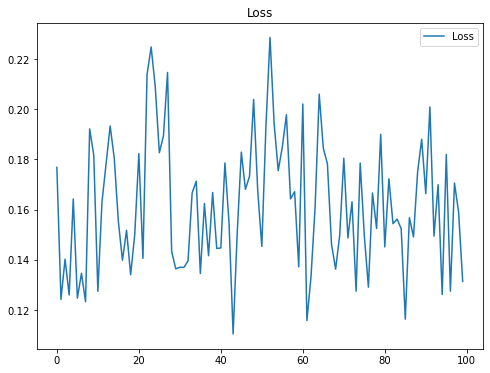

In [638]:
plt.figure(figsize = (8, 6))
plt.plot(Loss[-100:], label = 'Loss', markersize = 3)
plt.title("Loss")
plt.legend()
plt.show()

[[2.90084631]
 [3.97660386]
 [1.66066131]]


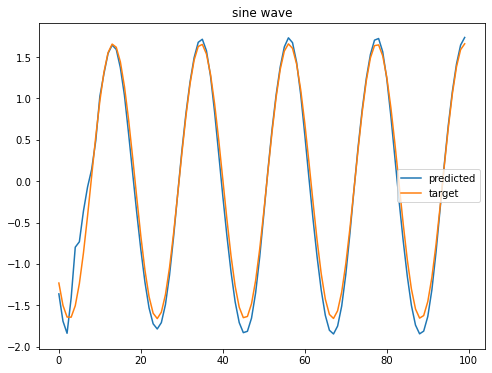

In [642]:
T = 100
parameters = np.random.uniform(1,5,(3,1))
print(parameters)
x = np.tile(parameters,(T))
time = np.linspace(0, 10, T)
frequency = x[0][0]
theta = x[1][0]
amplitude = x[2][0]
y = amplitude * np.sin(frequency * time + theta)

predicted = sinrnn.forward(x)
target = y
plt.figure(figsize = (8, 6))
plt.plot(predicted, label = 'predicted', markersize = 3)
plt.plot(target, label = 'target', markersize = 3)
plt.title("sine wave")
plt.legend()
plt.show()